## **Постановка задачи**


### **Описание данных**
1. **sales_df_train.csv** –данные по продажам за скользящий год для обучения.

Столбцы:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата;
- `pr_sales_type_id` – флаг наличия промо;
- `pr_sales_in_units` – число проданных товаров всего (промо и без);
- `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
- `pr_sales_in_rub` – продажи в РУБ всего (промо и без);
- `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ;

2. **pr_df.csv** – данные по товарной иерархии.
От большего к меньшему `pr_group_id` - `pr_cat_id` - `pr_subcat_id` - `pr_sku_id`.

Столбцы:
- `pr_group_id` – захэшированная группа товара;
- `pr_cat_id` – захэшированная категория товара;
- `pr_subcat_id` – захэшированная подкатегория товара;
- `pr_sku_id` – захэшированное id товара;
- `pr_uom_id` (маркер, обозначающий продаётся товар на вес или в ШТ).

3. **pr_st.csv** – данные по магазинам.

Столбцы:
- `st_id` – захэшированное id магазина;
- `st_city_id` – захэшированное id города;
- `st_division_code id` – захэшированное id дивизиона;
- `st_type_format_id` – id формата магазина;
- `st_type_loc_id` – id тип локации/окружения магазина;
- `st_type_size_id` – id типа размера магазина;
- `st_is_active` – флаг активного магазина на данный момент.

4. **sales_submission.csv** – пример файла с результатом работы модели прогноза спроса.
> Необходимо подготовить файл в таком же формате, заполнив колонку `target` предсказаниями (по умолчанию колонка заполнена нулями).

Столбцы:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата (день);
- `target` – спрос в ШТ.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from phik import phik_matrix

import math
import time
import re

# импортируем функции из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
from scipy import stats

# предварительная обработка
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# кроссвалидация
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit

# метрики
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error,  mean_squared_error


# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 42

In [2]:
#проект запускаю в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    #!pip install catboost
    !pip install orbit-ml >> None
    !"{sys.executable}" -m pip install phik >> None
    #!pip install matplotlib >> None

    print('Environment: Google Colab')

# импорт моделей
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
from orbit.utils.params_tuning import grid_search_orbit #подбор гиперпараметров
#from catboost import CatBoostRegressor

import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix


Environment: Google Colab


In [3]:
#если данные храняться на googledisk, подключаем его
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
try:
    data_train=pd.read_csv('/content/sales_df_train.csv', sep=',', parse_dates=[2]) #, index_col=[0], parse_dates=[0]
    data_st=pd.read_csv('/content/st_df.csv', sep=',') #магазины
    data_pr=pd.read_csv('/content/pr_df.csv', sep=',') #товарная иерархия
    data_sample=pd.read_csv('/content/sales_submission.csv', sep=',', parse_dates=[2])
    calendar=pd.read_csv('/content/holidays_covid_calendar.csv', sep=',', parse_dates=[3])
except:
    data_train=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/sales_df_train.csv', sep=',', parse_dates=[2]) #, index_col=[0], parse_dates=[0]
    data_st=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/st_df.csv', sep=',') #магазины
    data_pr=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/pr_df.csv', sep=',') #товарная иерархия
    data_sample=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/sales_submission.csv', sep=',', parse_dates=[2])
    calendar=pd.read_csv('/content/drive/MyDrive/ХАКАТОН/data/holidays_covid_calendar.csv', sep=',', parse_dates=[3])

## **Загрузка и первичный анализ данных**


In [5]:
#напишем функцию
def express_info(data, name):
    print(f'Информация {name}:')
    data.info()
    display(data.head(5))
    print()

In [6]:
express_info(data_train, 'train датасет')
express_info(data_pr, 'данных по товарной иерархии')
express_info(data_st, 'данных по магазинам')
express_info(data_sample, 'sample датасет')

Информация train датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814933 entries, 0 to 814932
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    814933 non-null  object        
 1   pr_sku_id                814932 non-null  object        
 2   date                     814932 non-null  datetime64[ns]
 3   pr_sales_type_id         814932 non-null  float64       
 4   pr_sales_in_units        814932 non-null  float64       
 5   pr_promo_sales_in_units  814932 non-null  float64       
 6   pr_sales_in_rub          814932 non-null  float64       
 7   pr_promo_sales_in_rub    814932 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 49.7+ MB


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1.0,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0.0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0.0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1.0,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0.0,1.0,0.0,161.0,0.0



Информация данных по товарной иерархии:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17



Информация данных по магазинам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1



Информация sample датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43694 entries, 0 to 43693
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   st_id      43694 non-null  object        
 1   pr_sku_id  43694 non-null  object        
 2   date       43694 non-null  datetime64[ns]
 3   target     43694 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB


,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0


In [7]:
#напишем функцию для исследования данных
def research(data, name, figsize, silent):
    print(f'Размер данных:      {data.shape}')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print(f'Наличие пропусков:           {data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')
    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(data.isna().mean()*100).sort_values(ascending=False).head(15))
    #data.info()
    if not silent:
        print(f'\nПроверка структуры {name}:')
        data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распеределения {name}', y=0.95, fontsize=12)
        plt.show()

        print()
        #тепловая карта корреляций
        plt.figure(figsize=(6, 6))
        matrix = np.triu(data.corr())
        heatmap = sns.heatmap(data.corr(), annot=True, fmt='.2g',
                          mask=matrix, square=True,
                          cmap='GnBu',  cbar=False,
                          xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)#'coolwarm', cmap=cmap,'Blues','BuGn'
        plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.90, fontsize=12)
        plt.show()
        print()
        display(data.describe())
#    if silent:
#        print(f'Корреляция {name}')
#        display(data.corr().round(3)\
#                .style\
#                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))
    display(data.head(5))

Размер данных:      (814933, 8)
Количество явных дубликатов: 0
Наличие пропусков:           7
Пропущенные данные (в процентном соотношении):
st_id                      0.0
pr_sku_id                  0.0
date                       0.0
pr_sales_type_id           0.0
pr_sales_in_units          0.0
pr_promo_sales_in_units    0.0
pr_sales_in_rub            0.0
pr_promo_sales_in_rub      0.0
dtype: float64

Проверка структуры train данных:


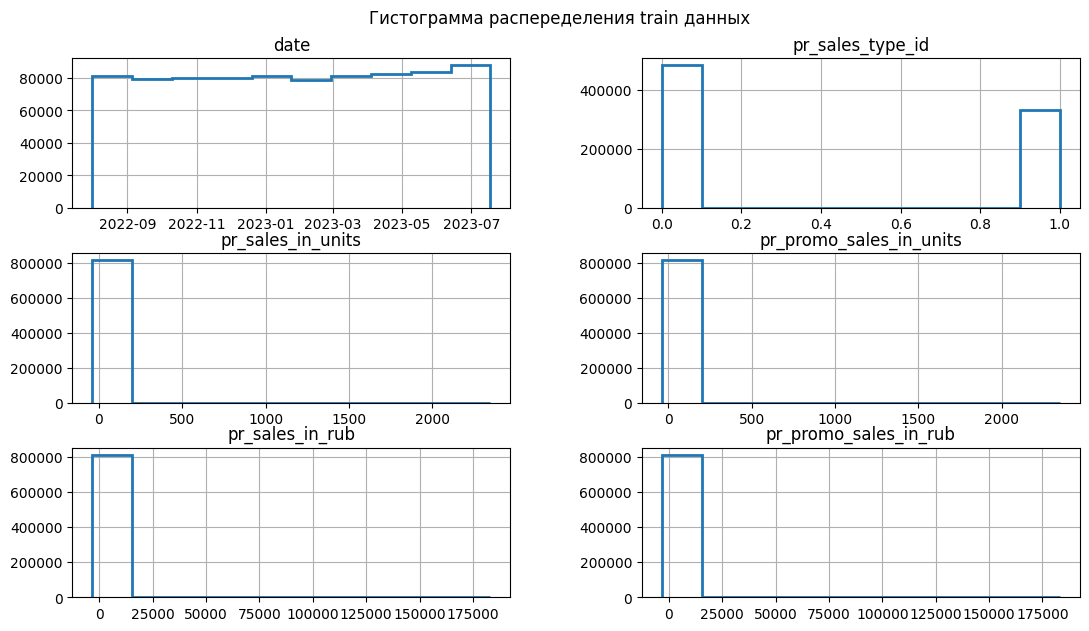

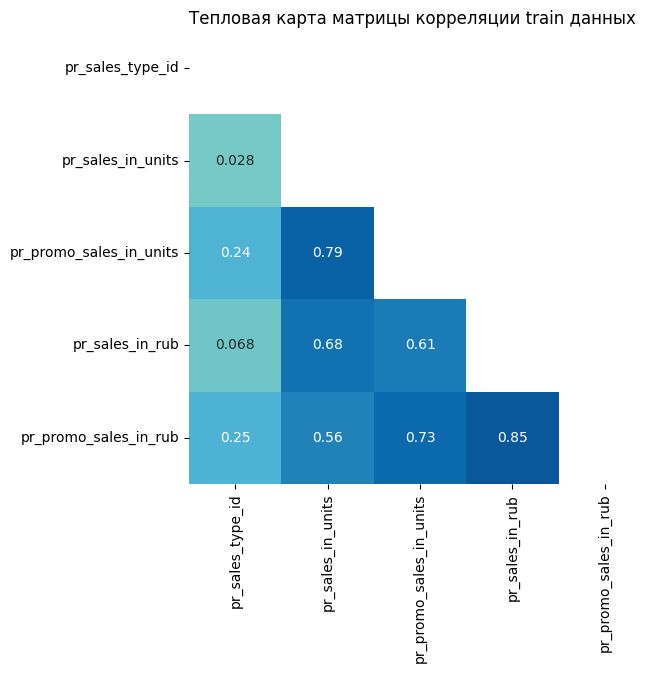

,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
count,814932.000000,814932.000000,814932.000000,814932.000000,814932.000000
mean,0.406332,5.032843,2.227972,596.467904,294.761137
std,0.491148,13.365771,11.083394,1574.390318,1401.465435
min,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000
25%,0.000000,1.000000,0.000000,98.000000,0.000000
50%,0.000000,2.000000,0.000000,224.000000,0.000000
75%,1.000000,4.000000,1.000000,540.000000,127.000000
max,1.000000,2348.000000,2348.000000,183265.000000,183265.000000


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1.0,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0.0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0.0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1.0,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0.0,1.0,0.0,161.0,0.0


Размер данных:      (12, 7)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
st_id                0.0
st_city_id           0.0
st_division_code     0.0
st_type_format_id    0.0
st_type_loc_id       0.0
st_type_size_id      0.0
st_is_active         0.0
dtype: float64

Проверка структуры данных по магазинам:


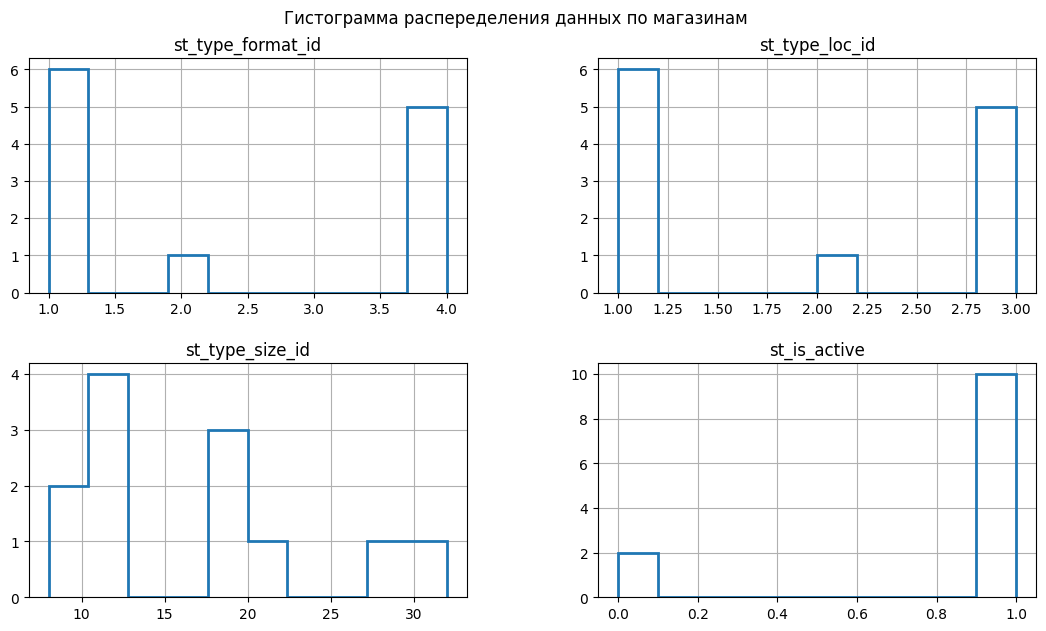

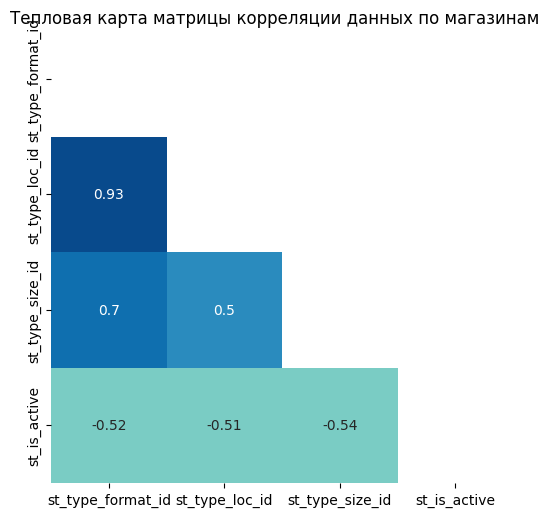

,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,12.000000,12.000000,12.000000,12.000000
mean,2.333333,1.916667,16.750000,0.833333
std,1.497473,0.996205,7.557356,0.389249
min,1.000000,1.000000,8.000000,0.000000
25%,1.000000,1.000000,12.000000,1.000000
50%,1.500000,1.500000,15.500000,1.000000
75%,4.000000,3.000000,19.250000,1.000000
max,4.000000,3.000000,32.000000,1.000000


,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1


In [8]:
research(data_train, 'train данных', figsize=(13, 7), silent=False)
research(data_st, 'данных по магазинам', figsize=(13, 7), silent=False)

In [9]:
research(data_pr, 'данных по товарной иерархии', figsize=((13, 7)), silent=True)
research(data_sample, 'sample датасет', figsize=((13, 7)), silent=True)

Размер данных:      (2050, 5)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
pr_sku_id       0.0
pr_group_id     0.0
pr_cat_id       0.0
pr_subcat_id    0.0
pr_uom_id       0.0
dtype: float64


,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


Размер данных:      (43694, 4)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
st_id        0.0
pr_sku_id    0.0
date         0.0
target       0.0
dtype: float64


,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0


In [10]:
express_info(calendar, 'календарь')
#research(calendar, 'sample датасет', figsize=((13, 7)), silent=True)

Информация календарь:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     3653 non-null   int64         
 1   day      3653 non-null   int64         
 2   weekday  3653 non-null   int64         
 3   date     3653 non-null   datetime64[ns]
 4   calday   3653 non-null   int64         
 5   holiday  3653 non-null   int64         
 6   covid    3653 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 199.9 KB


,year,day,weekday,date,calday,holiday,covid
0,2015,1,4,2015-01-01,20150101,1,0
1,2015,2,5,2015-02-01,20150102,1,0
2,2015,3,6,2015-03-01,20150103,1,0
3,2015,4,7,2015-04-01,20150104,1,0
4,2015,5,1,2015-05-01,20150105,1,0


In [11]:
#в календарь праздников добавим `month`
calendar['month']=pd.DatetimeIndex(calendar['date']).month
calendar['month'] = pd.to_numeric(calendar['month'], errors='coerce')
calendar = calendar[['date','year', 'month', 'weekday', 'day', 'holiday',  'calday','covid']]
express_info(calendar, 'календарь')

Информация календарь:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     3653 non-null   datetime64[ns]
 1   year     3653 non-null   int64         
 2   month    3653 non-null   int64         
 3   weekday  3653 non-null   int64         
 4   day      3653 non-null   int64         
 5   holiday  3653 non-null   int64         
 6   calday   3653 non-null   int64         
 7   covid    3653 non-null   int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 228.4 KB


,date,year,month,weekday,day,holiday,calday,covid
0,2015-01-01,2015,1,4,1,1,20150101,0
1,2015-02-01,2015,2,5,2,1,20150102,0
2,2015-03-01,2015,3,6,3,1,20150103,0
3,2015-04-01,2015,4,7,4,1,20150104,0
4,2015-05-01,2015,5,1,5,1,20150105,0


In [12]:
#scatterplot
#sns.set()
#ols = ['pr_sales_in_rub', 'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_type_id', 'pr_promo_sales_in_rub']
#sns.pairplot(data_train[cols], size = 2.5)
#plt.show();

####Выводы:
- пропусков и явных дубликатов в данных нет.
- тепловая карта показала, явную корреляцию в `pr_sales_in_units` и `pr_promo_sales_in_units`, `pr_sales_in_rub` и `pr_promo_sales_in_rub`, что логично, так как одни данные являются частью других (возможно при формировании признаков надо будет удалить один из столбцов в парах).
- Также проверка структуры данных по магазинам показала высокую корреляцию между форматом магазина и локацией. Видимо, от локации зависит тип магазина. Также формат магазина коррелирует с размером - тоже логично. Скорее всего при формировании признаков будем удалять формат магазина.
- сразу подготовили данные табдицы календаря с праздниками к работе (добавили столбец с месяцем месяц)
- Из анализа зависимости числовых явная линейная зависимость между количеством продаж и суммы продаж, что логично, также общих продаж от промопродаж, с большим количеством выбросов в 0 (надо будет более детально исследовать эту зависимость)
- объединим датасеты в один по дате.

## **Разведочный анализ данных**
>(День — Товар — Магазин — Продажа в штуках — Продажа в рублях — доля продаж по ПРОМО)

- Построить графики временных рядов
- Исследовать пропуски, выбросы и корреляции между товарами, заполнить пропуски, нивелировать выбросы
- Провести предобработку данных
- **Исследовать признаки**
    - Посчитать цены
        - Стоимость одного товара (за день)
        - Стоимость группы товаров (за день)

#### Объединим датасеты в один по дате

In [13]:
data_merge = pd.merge(data_train, data_pr, on='pr_sku_id', how='left')
data_merge = pd.merge(data_merge, data_st, on='st_id', how='left')
data_merge.head(3)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1.0,5.0,5.0,825.0,825.0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1.0,1.0,8.0,1.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0.0,4.0,0.0,196.0,0.0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1.0,1.0,12.0,1.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0.0,1.0,0.0,78.0,0.0,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2.0,1.0,28.0,1.0


In [14]:
data_merge = data_merge[['date', 'pr_sales_type_id', 'pr_sales_in_units','pr_promo_sales_in_units',\
       'pr_sales_in_rub', 'pr_promo_sales_in_rub','st_id', 'pr_sku_id',\
       'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_type_format_id', 'st_type_loc_id',\
       'st_type_size_id', 'st_is_active', 'st_city_id','st_division_code']]


In [15]:
#data.columns
express_info(data_merge, 'по объедененному датасету')
research(data_merge, 'данных по объедененному датасету', figsize=(15, 10), silent=True)

Информация по объедененному датасету:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 814933 entries, 0 to 814932
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     814932 non-null  datetime64[ns]
 1   pr_sales_type_id         814932 non-null  float64       
 2   pr_sales_in_units        814932 non-null  float64       
 3   pr_promo_sales_in_units  814932 non-null  float64       
 4   pr_sales_in_rub          814932 non-null  float64       
 5   pr_promo_sales_in_rub    814932 non-null  float64       
 6   st_id                    814933 non-null  object        
 7   pr_sku_id                814932 non-null  object        
 8   pr_group_id              814932 non-null  object        
 9   pr_cat_id                814932 non-null  object        
 10  pr_subcat_id             814932 non-null  object        
 11  pr_uom_id                814932 non-null

,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_id,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,st_city_id,st_division_code
0,2022-10-20,1.0,5.0,5.0,825.0,825.0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1.0,1.0,1.0,8.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
1,2023-01-29,0.0,4.0,0.0,196.0,0.0,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
2,2023-03-02,0.0,1.0,0.0,78.0,0.0,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17.0,2.0,1.0,28.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
3,2023-04-05,1.0,0.0,0.0,69.0,69.0,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
4,2023-02-17,0.0,1.0,0.0,161.0,0.0,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1.0,1.0,2.0,8.0,1.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130



Размер данных:      (814933, 18)
Количество явных дубликатов: 0
Наличие пропусков:           17
Пропущенные данные (в процентном соотношении):
date                     0.0
pr_sales_type_id         0.0
st_city_id               0.0
st_is_active             0.0
st_type_size_id          0.0
st_type_loc_id           0.0
st_type_format_id        0.0
pr_uom_id                0.0
pr_subcat_id             0.0
pr_cat_id                0.0
pr_group_id              0.0
pr_sku_id                0.0
st_id                    0.0
pr_promo_sales_in_rub    0.0
pr_sales_in_rub          0.0
dtype: float64


,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_id,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,st_city_id,st_division_code
0,2022-10-20,1.0,5.0,5.0,825.0,825.0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1.0,1.0,1.0,8.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
1,2023-01-29,0.0,4.0,0.0,196.0,0.0,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
2,2023-03-02,0.0,1.0,0.0,78.0,0.0,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17.0,2.0,1.0,28.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
3,2023-04-05,1.0,0.0,0.0,69.0,69.0,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
4,2023-02-17,0.0,1.0,0.0,161.0,0.0,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1.0,1.0,2.0,8.0,1.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130


In [16]:
# сделаем дату индексом и добавим календарь праздников в наш датасет
data_merge.set_index('date', inplace=True)
calendar.set_index('date', inplace=True)

In [17]:
data = pd.merge(calendar, data_merge, left_index=True, right_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 814932 entries, 2022-08-01 to 2023-07-18
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   year                     814932 non-null  int64  
 1   month                    814932 non-null  int64  
 2   weekday                  814932 non-null  int64  
 3   day                      814932 non-null  int64  
 4   holiday                  814932 non-null  int64  
 5   calday                   814932 non-null  int64  
 6   covid                    814932 non-null  int64  
 7   pr_sales_type_id         814932 non-null  float64
 8   pr_sales_in_units        814932 non-null  float64
 9   pr_promo_sales_in_units  814932 non-null  float64
 10  pr_sales_in_rub          814932 non-null  float64
 11  pr_promo_sales_in_rub    814932 non-null  float64
 12  st_id                    814932 non-null  object 
 13  pr_sku_id                814932 non-null  o

In [18]:
research(data, 'данных по объедененному датасету', figsize=(15, 10), silent=True)

Размер данных:      (814932, 24)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
year                     0.0
month                    0.0
st_city_id               0.0
st_is_active             0.0
st_type_size_id          0.0
st_type_loc_id           0.0
st_type_format_id        0.0
pr_uom_id                0.0
pr_subcat_id             0.0
pr_cat_id                0.0
pr_group_id              0.0
pr_sku_id                0.0
st_id                    0.0
pr_promo_sales_in_rub    0.0
pr_sales_in_rub          0.0
dtype: float64


,year,month,weekday,day,holiday,calday,covid,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,...,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,st_city_id,st_division_code
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,20220108,0,1.0,0.0,0.0,...,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,1.0,1.0,1.0,8.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
2022-08-01,2022,8,6,8,1,20220108,0,0.0,21.0,0.0,...,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17.0,1.0,1.0,8.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
2022-08-01,2022,8,6,8,1,20220108,0,1.0,1.0,1.0,...,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b3e70d072fc648f6934c288e44f5c35e,1.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
2022-08-01,2022,8,6,8,1,20220108,0,0.0,6.0,0.0,...,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
2022-08-01,2022,8,6,8,1,20220108,0,1.0,1.0,1.0,...,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,1.0,1.0,1.0,12.0,1.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99


In [19]:
# Проверить наличие пропусков в индексе DataFrame
has_missing_index = data.index.isna().any()
if has_missing_index:
    print("В индексе есть пропущенные значения.")
else:
    print("Пропущенных значений в индексе нет.")

Пропущенных значений в индексе нет.


In [20]:
# проверим последовательность данных
print("Индекс монотонно возрастающий:", data.index.is_monotonic_increasing)

Индекс монотонно возрастающий: True


In [21]:
#удалим неинформативные признаки из календаря
# удалим признаки
data = data.drop(['covid','calday'], axis=1) #,'year'
data.head()
#research(data, 'данных по объедененному датасету', figsize=(15, 10), silent=True)

,year,month,weekday,day,holiday,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,...,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,st_city_id,st_division_code
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,1.0,0.0,0.0,79.0,79.0,...,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,1.0,1.0,1.0,8.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
2022-08-01,2022,8,6,8,1,0.0,21.0,0.0,462.0,0.0,...,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17.0,1.0,1.0,8.0,1.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
2022-08-01,2022,8,6,8,1,1.0,1.0,1.0,154.0,154.0,...,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,b3e70d072fc648f6934c288e44f5c35e,1.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
2022-08-01,2022,8,6,8,1,0.0,6.0,0.0,860.0,0.0,...,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1.0,1.0,1.0,12.0,1.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
2022-08-01,2022,8,6,8,1,1.0,1.0,1.0,57.0,57.0,...,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,1.0,1.0,1.0,12.0,1.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99


### **Активные магазины**
Определим активные магазины с которыми будем работать

In [22]:
#Напишем функцию
def plot_pie(data, title):
  graph = data.value_counts()\
  .plot.pie(legend=True,labeldistance=1.1, autopct='%1.2f%%', figsize=(5,5))
  plt.title(title)
  plt.show()

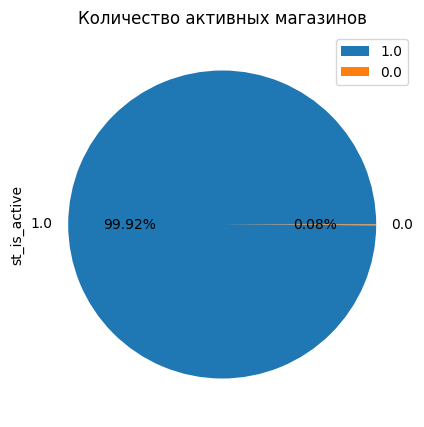

In [23]:
plot_pie(data['st_is_active'], 'Количество активных магазинов')
#1-активные, 0-неактивные

In [24]:
#Определим неактивные магазины
no_active_st_id = data[data['st_is_active'] != 1].groupby('st_id')['st_is_active'].sum()
no_active_st_id

st_id
1aa057313c28fa4a40c5bc084b11d276    0.0
62f91ce9b820a491ee78c108636db089    0.0
Name: st_is_active, dtype: float64

In [25]:
# продажи в магазинах
df_pivot = data.pivot_table(
    index=['st_id'], values=['pr_sales_in_units', 'pr_promo_sales_in_units'],
    aggfunc=sum
    ).sort_values(by='pr_sales_in_units', ascending=True)
df_pivot

,pr_promo_sales_in_units,pr_sales_in_units
st_id,,
62f91ce9b820a491ee78c108636db089,29.0,35.0
084a8a9aa8cced9175bd07bc44998e75,27.0,44.0
1aa057313c28fa4a40c5bc084b11d276,360.0,2021.0
bd470ca955d9497bbcb808e59952fffc,3313.0,4741.0
53e19f3dbb211f20b20b45668303c1b6,9463.0,17772.0
1ecfb463472ec9115b10c292ef8bc986,47995.0,119141.0
6364d3f0f495b6ab9dcf8d3b5c6e0b01,244743.0,488305.0
fa7cdfad1a5aaf8370ebeda47a1ff1c3,213275.0,490493.0
f7e6c85504ce6e82442c770f7c8606f0,261139.0,619886.0


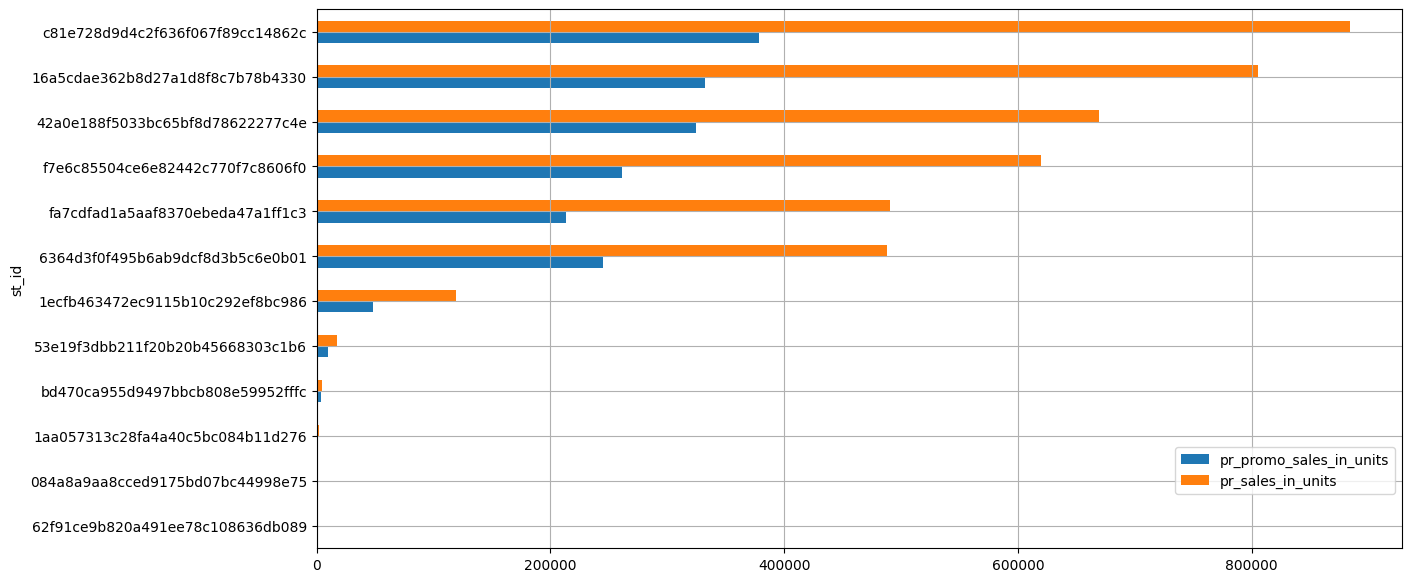

In [26]:
# Визуализируем продажи в магазинах
ax = df_pivot.plot(kind='barh', grid=True, figsize=(14, 7))
ax.legend(loc='best', bbox_to_anchor=(1, 0.2));

In [27]:
list_store = data['st_id'].unique().tolist()
# список для хранения данных о магазинах и их количестве дней работы
store_data = []

for store in list_store:
    min_date = data.loc[data['st_id'] == store].index.min().date()
    max_date = data.loc[data['st_id'] == store].index.max().date()
    delta = max_date - min_date
    days = delta.days
    store_data.append({'store': store, 'days_worked': days})

# сотируем магазины по количеству дней работы
sorted_stores = sorted(store_data, key=lambda x: x['days_worked'], reverse=True)

# сортируем магазины по дням работы
for store_info in sorted_stores:
    store = store_info['store']
    days = store_info['days_worked']
    print("Магазин:", store, 'работал', days, 'дней')
    print("=" * 60)

Магазин: c81e728d9d4c2f636f067f89cc14862c работал 351 дней
Магазин: 42a0e188f5033bc65bf8d78622277c4e работал 351 дней
Магазин: f7e6c85504ce6e82442c770f7c8606f0 работал 351 дней
Магазин: 6364d3f0f495b6ab9dcf8d3b5c6e0b01 работал 351 дней
Магазин: 16a5cdae362b8d27a1d8f8c7b78b4330 работал 351 дней
Магазин: fa7cdfad1a5aaf8370ebeda47a1ff1c3 работал 351 дней
Магазин: 1ecfb463472ec9115b10c292ef8bc986 работал 351 дней
Магазин: 53e19f3dbb211f20b20b45668303c1b6 работал 351 дней
Магазин: bd470ca955d9497bbcb808e59952fffc работал 326 дней
Магазин: 084a8a9aa8cced9175bd07bc44998e75 работал 95 дней
Магазин: 1aa057313c28fa4a40c5bc084b11d276 работал 30 дней
Магазин: 62f91ce9b820a491ee78c108636db089 работал 15 дней


#### Удалим магазины с малой активностью

In [28]:
# cоздаем булевую маску для строк на удаления
mask = (data['st_id'] == '1aa057313c28fa4a40c5bc084b11d276') | (data['st_id'] == '62f91ce9b820a491ee78c108636db089') | (data['st_id'] == '084a8a9aa8cced9175bd07bc44998e75')
# удаляем строки, соответствующие маске
activ_store = data[~mask]
print('Количество активных магазинов:', activ_store['st_id'].value_counts().count())

Количество активных магазинов: 9


In [29]:
# удалим столбцец 'st_is_active' за ненадобностью
activ_store = activ_store.drop('st_is_active', axis=1)
activ_store.columns

Index(['year', 'month', 'weekday', 'day', 'holiday', 'pr_sales_type_id',
       'pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub',
       'pr_promo_sales_in_rub', 'st_id', 'pr_sku_id', 'pr_group_id',
       'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_type_format_id',
       'st_type_loc_id', 'st_type_size_id', 'st_city_id', 'st_division_code'],
      dtype='object')

Вывод:
- Магазин, в котором наблюдаются наибольшие продажи `'c81e728d9d4c2f636f067f89cc14862c'` - в дальнейшем на нем будем тестировать модель.
- Выявили неактивные магазины и удалили их - их оказалось 3 шт;
- Адалили столбец 'st_is_active', так как теперь он неинформанивнен.

### **Исследуем признаки**
> напишем функцию исследования признаков

In [30]:
#напишем функцию для изучения данных в столбцах
def feed_size(data, state, name_state): #x_lim0,,  x_lim
    print(f'Статистические данные о распределении значений {name_state} ({state}):')
    display(data[f'{state}'].describe())

    plt.subplots(figsize=(12, 1))
    #plt.xlim([0,x_lim])#x_lim0,
    plt.title(f'Диаграмма рассеяния {name_state} ({state})')
    sns.boxplot(x=data[f'{state}'], palette='pastel', data=data[f'{state}'])
    plt.show()

    plt.figure(figsize=(12, 2))
    #sns.kdeplot(data[f'{state}'], fill=True, label=f'{state} {name_state}', alpha=0.6, shade=True)
    sns.histplot(data[f'{state}'], bins=150, color="seagreen", label=f'{name_state}', alpha=0.7, kde=True)
    #sns.distplot(data[f'{state}'], color="seagreen", label=f'{name_state}', fit=norm);
    #plt.xlim([0,x_lim]) #x_lim0,
    plt.xlabel(f'{state}')
    plt.ylabel(f'Распределение вероятности \nнепрерывной величины', fontsize=10)
    plt.legend(loc='upper right')
    plt.title(f'Гистограмма распределения {name_state} ({state})', fontsize=12)
    #fig = plt.figure()
    #res = stats.probplot(data[f'{state}'], plot=plt)
    plt.show()

In [31]:
#histogram and normal probability plot
def graph(data, name):
    sns.distplot(data[name], fit=norm);
    #plt.xlim([0,55000])
    fig = plt.figure()
    plt.show()
    #проверим на нормальность
    res = stats.probplot(data[name], plot=plt)
    #Посчитаем Ассиметрию и Эксцесс
    print("Ассиметрия:%f" % data[name].skew())
    print("Эксцесс: %f" % data[name].kurt())
    print("Среднее : %f" % data[name].mean())
    print("Отклонение  %f" % data[name].var())

### **Целевой признак - `pr_sales_in_units`**

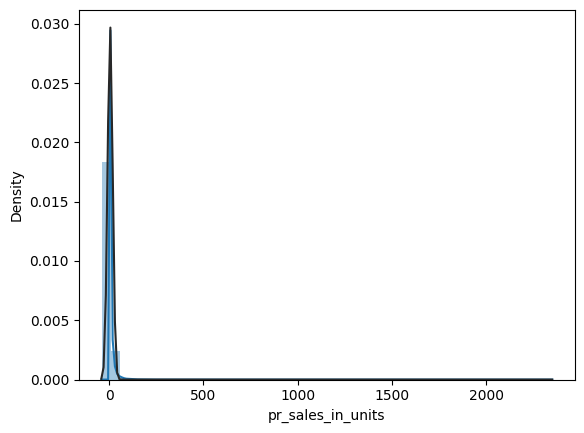

<Figure size 640x480 with 0 Axes>

Ассиметрия:32.362282
Эксцесс: 3038.690348
Среднее : 5.034498
Отклонение  178.786876


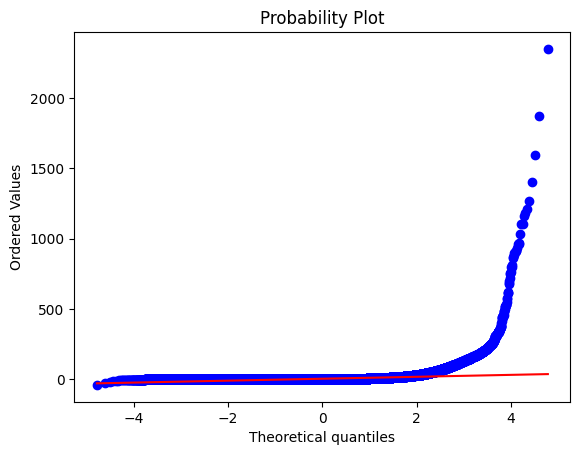

In [32]:
#graph(data)
graph(activ_store, 'pr_sales_in_units')

Статистические данные о распределении значений общие продажи (pr_sales_in_units):


count    814247.000000
mean          5.034498
std          13.371121
min         -39.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

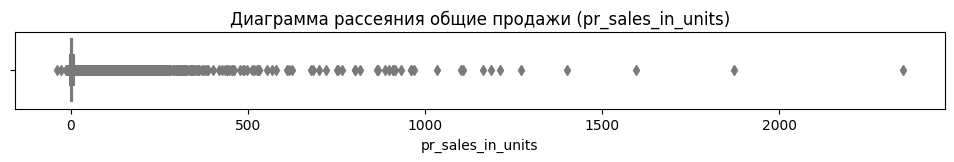

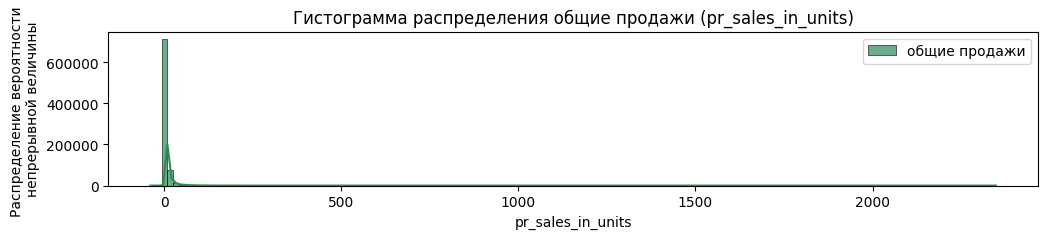

In [33]:
feed_size(activ_store, 'pr_sales_in_units', 'общие продажи')#, 2000

In [34]:
activ_store[activ_store['pr_sales_in_units'] < 0] #.value_counts('pr_sales_in_units').sum() #count()

,year,month,weekday,day,holiday,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,...,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,st_city_id,st_division_code
date,,,,,,,,,,,,,,,,,,,,,
2022-08-07,2022,8,5,8,0,0.0,-1.0,0.0,-312.0,0.0,...,e79eb35132023b80bd8610a4ee16e52d,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,3d15a2a1c540356f9716dc265dd92382,1.0,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
2022-08-09,2022,8,4,8,0,0.0,-2.0,0.0,-411.0,0.0,...,be2eb3bcc9ebeba04e0441004e9a674b,c51ce410c124a10e0db5e4b97fc2af39,fd5c905bcd8c3348ad1b35d7231ee2b1,3dde95bfddfc5c387eb9e7b7a77dfa63,1.0,1.0,1.0,12.0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130
2022-08-26,2022,8,5,26,0,1.0,-9.0,-9.0,-204.0,-204.0,...,9a3e6ab0f0e9396f7af956fe6e45b407,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17.0,1.0,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30
2022-08-29,2022,8,1,29,0,1.0,-1.0,-1.0,-109.0,-109.0,...,f0b2b0e013970cb4e096e3dbc561f434,aab3238922bcc25a6f606eb525ffdc56,3de2334a314a7a72721f1f74a6cb4cee,0f3abfd67959c079e7b3759440e7415c,17.0,1.0,1.0,12.0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130
2022-08-30,2022,8,2,30,0,0.0,-2.0,0.0,-424.0,0.0,...,f2be582e5deaaa8558adfdcd1c92a6ac,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1.0,1.0,2.0,8.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-18,2023,6,7,18,1,1.0,-4.0,-4.0,-960.0,-960.0,...,1933ead077ee71dda8c85a7b769c8ef6,c51ce410c124a10e0db5e4b97fc2af39,5caf41d62364d5b41a893adc1a9dd5d4,4e96157c3c8c24f4761a7bc4411a2504,1.0,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c
2023-06-22,2023,6,4,22,0,1.0,-4.0,-4.0,-463.0,-463.0,...,b32d54edfbef54504db682d7d6d5be8d,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,c005b9a2626f6c1946e1851628724b18,1.0,1.0,1.0,12.0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130
2023-07-06,2023,7,3,7,0,0.0,-2.0,0.0,-402.0,0.0,...,40c651c778ea5ff2c54b164483dbae9c,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,0f82166e64f8132fbdca4d49816e2ce4,1.0,1.0,2.0,8.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130


In [35]:
#Удалим отрицательные значения
mask = (activ_store['pr_sales_in_rub'] <= 0)
# удаляем строки, соответствующие маске, из data
activ_store = activ_store[~mask]
activ_store[activ_store['pr_sales_in_units'] < 0].value_counts('pr_sales_in_units').sum()

0

In [36]:
print('Исходные данные:' , len(data))
print('Очищенные данные:', len(activ_store))
print(f'Удалено {((len(data) - len(activ_store))/(len(data))):.2%} от исходных данных')

Исходные данные: 814932
Очищенные данные: 813034
Удалено 0.23% от исходных данных


#### **Нулевые значения в целевом признаке**

In [37]:
# строки с нулевым значением в столбце число проданных товаров
null_pr_sales_in_units = activ_store[activ_store['pr_sales_in_units'] == 0]
null_pr_sales_in_units.value_counts('pr_sales_in_units').sum()

60998

In [38]:
# Заполним нули в столбце pr_sales_in_units
# меням 0 на пропуски
activ_store['pr_sales_in_units'] = activ_store['pr_sales_in_units'].replace(0, np.nan)
# заменим пропуски на значение стори снизу
activ_store['pr_sales_in_units'] = activ_store['pr_sales_in_units'].fillna(method='ffill')
# первую стороку заполним средним значением столбца
activ_store['pr_sales_in_units'] = activ_store['pr_sales_in_units'].fillna(activ_store['pr_sales_in_units'].mean())
# приведем к целым значениям
activ_store['pr_sales_in_units'] = activ_store['pr_sales_in_units'].astype(int)
activ_store['pr_promo_sales_in_units'] = activ_store['pr_promo_sales_in_units'].astype(int)

In [39]:
# Проверим количество нулей в целевом признаке
activ_store[activ_store['pr_sales_in_units'] == 0].value_counts('pr_sales_in_units').sum()

0

#### Преобразуем распределение целевого признака в нормальное распределение - `'pr_sales_in_units_log'`


In [40]:
#applying log transformation
activ_store['pr_sales_in_units_log'] = np.log(activ_store['pr_sales_in_units'])

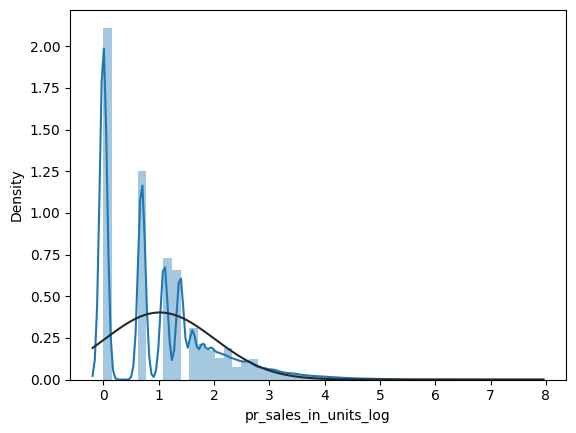

<Figure size 640x480 with 0 Axes>

Ассиметрия:0.979086
Эксцесс: 0.811745
Среднее : 1.019491
Отклонение  0.981517


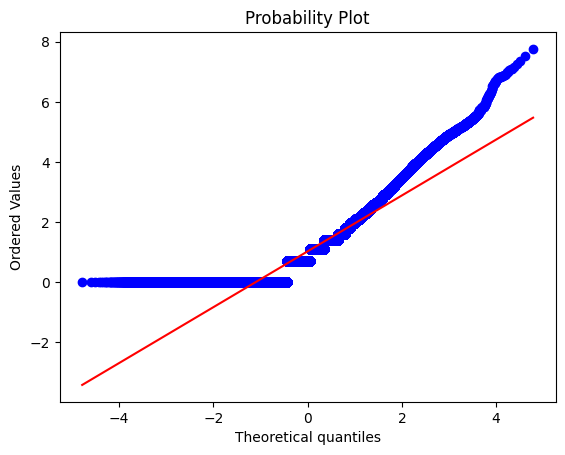

In [41]:
graph(activ_store, 'pr_sales_in_units_log')

**Вывод:**
- Распределение целевых значений отличается от нормального.
- Имеет заметную положительную асимметрию.
- Является остроконечным.
- наблюдаются отрицательные значения (71шт) - мы не можем определить причину, поэтому удаляем их.
- Проверили на нулевые значения в столбце целевого признака - заполнили нули значениями из строк ниже
- преобразовали распределение целевого признака в более нормальный вид - новый признак`'pr_sales_in_units_log'`

### **Исследуем дополнительные признаки**

Исследуем признаки `pr_sales_in_units` и `pr_promo_sales_in_units`, `pr_sales_type_id`, `date` и `pr_promo_sales_in_rub`.
- `date` – дата;
- `pr_sales_type_id` – флаг наличия промо;
- `pr_sales_in_units` – число проданных товаров всего (промо и без);
- `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
- `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ;

#### Отношения с непрерывными признаками

In [42]:
#напишем функцию scatter plot
#var=[]
def scatter_plot(data, var_target, var):
    data = pd.concat([data[var_target], data[var]], axis=1)
    data.plot.scatter(x=var, y=var_target); #, xlim=(0,25000), ylim=(0,175000)

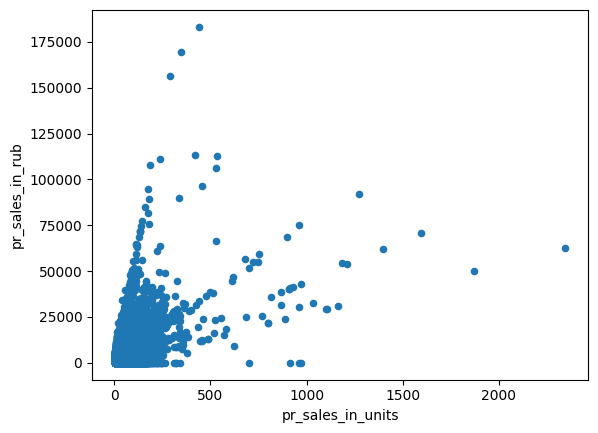

In [43]:
#scatter plot pr_sales_in_units/pr_sales_in_rub
scatter_plot(activ_store, 'pr_sales_in_rub', 'pr_sales_in_units')
#scatter_plot(activ_store, 'pr_sales_in_rub', 'pr_sales_in_units_log')

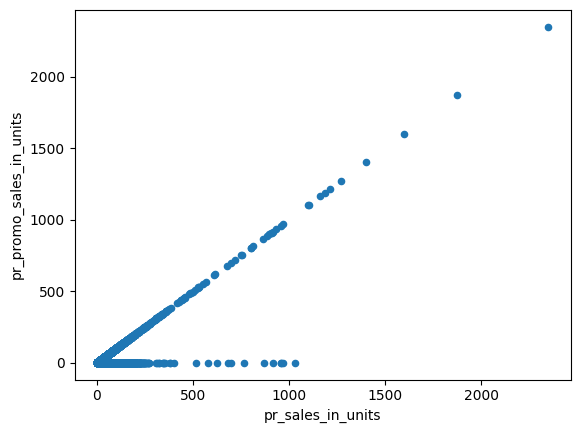

In [44]:
#scatter plot pr_sales_in_units/pr_sales_in_units
scatter_plot(activ_store, 'pr_promo_sales_in_units', 'pr_sales_in_units')

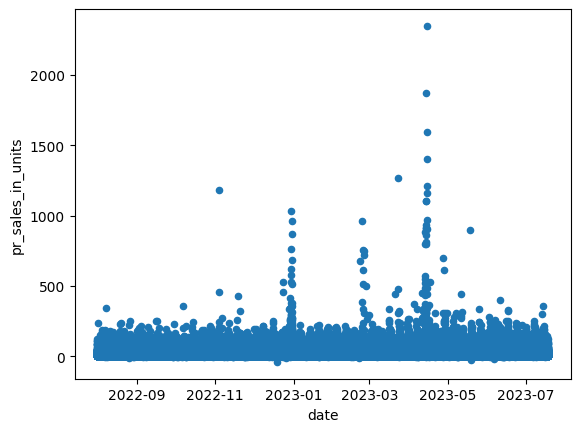

In [45]:
#scatter pr_sales_in_units/date
scatter_plot(data_train, 'pr_sales_in_units', 'date')

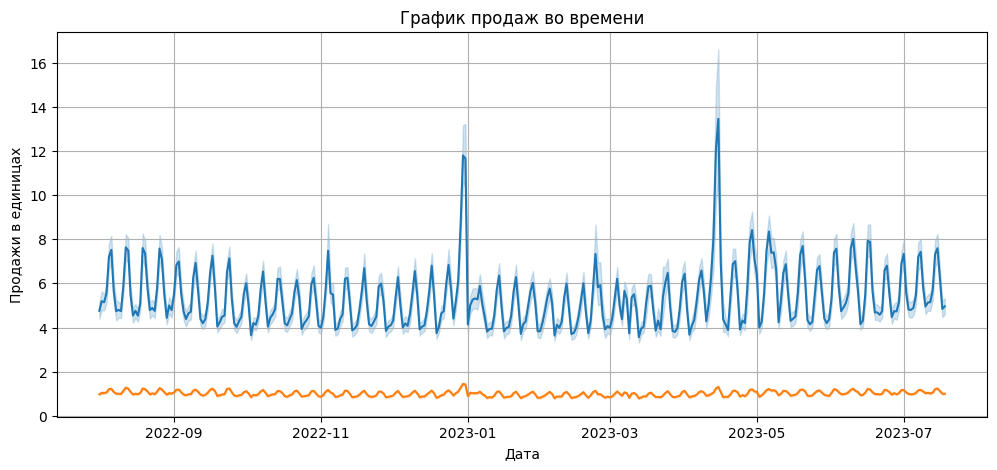

In [46]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=activ_store, x=activ_store.index, y="pr_sales_in_units")
sns.lineplot(data=activ_store, x=activ_store.index, y="pr_sales_in_units_log")
plt.xlabel("Дата")
plt.ylabel("Продажи в единицах")
plt.title("График продаж во времени")
plt.grid(True)
plt.show()

### **Проведем анализ временных рядов**

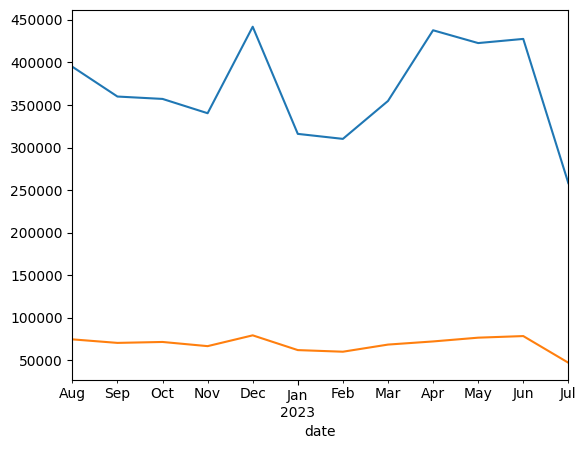

In [47]:
activ_store_m = activ_store['pr_sales_in_units'].resample('1M').sum()
activ_store_ml = activ_store['pr_sales_in_units_log'].resample('1M').sum() #.mean()
activ_store_m.plot()
activ_store_ml.plot();

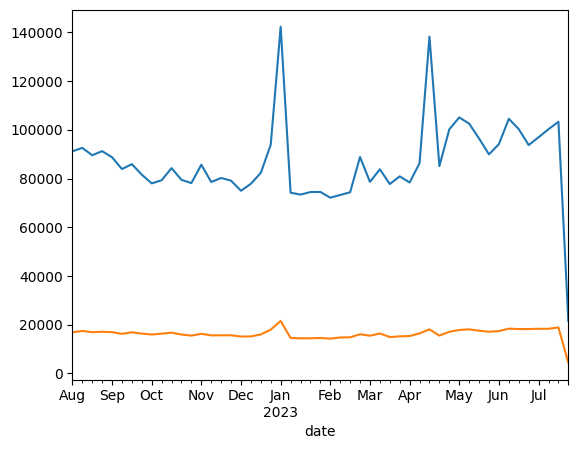

In [48]:
data_w = activ_store['pr_sales_in_units'].resample('1W').sum()
data_wl = activ_store['pr_sales_in_units_log'].resample('1W').sum()
data_w.plot()
data_wl.plot();

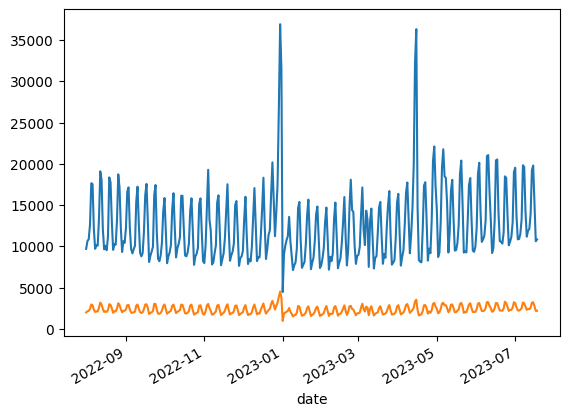

In [49]:
activ_store['pr_sales_in_units_res'] = activ_store['pr_sales_in_units'].resample('1D').sum()
data_d = activ_store['pr_sales_in_units'].resample('1D').sum()
activ_store['pr_sales_in_units_lres'] = activ_store['pr_sales_in_units_log'].resample('1D').sum()
activ_store['pr_sales_in_units_res'].plot()
activ_store['pr_sales_in_units_lres'].plot();

In [50]:
activ_store.head()

,year,month,weekday,day,holiday,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,...,pr_subcat_id,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,st_city_id,st_division_code,pr_sales_in_units_log,pr_sales_in_units_res,pr_sales_in_units_lres
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,1.0,5,0,79.0,79.0,...,8afe22eeb3f3f68de994a3c60388858c,1.0,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1.609438,9699,1994.558628
2022-08-01,2022,8,6,8,1,0.0,21,0,462.0,0.0,...,e06f5ed77191826c212c30722f2cc5a2,17.0,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,3.044522,9699,1994.558628
2022-08-01,2022,8,6,8,1,1.0,1,1,154.0,154.0,...,b3e70d072fc648f6934c288e44f5c35e,1.0,1.0,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,0.000000,9699,1994.558628
2022-08-01,2022,8,6,8,1,0.0,6,0,860.0,0.0,...,c01c475ac8d447730ece97d846cc4f25,1.0,1.0,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1.791759,9699,1994.558628
2022-08-01,2022,8,6,8,1,1.0,1,1,57.0,57.0,...,89b0107c6d0aca5f15fa7a715f9e06e5,1.0,1.0,1.0,12.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,0.000000,9699,1994.558628


Вывод:
- При логарифмировании целевого признака наблюдаем меньший размах данных, проверим, как будет вести себя модель при использовании нормализованного признака.

Посмотрим поведение ресемплированных данных за последний период **в май-июнь** на разных промежутках времени

In [51]:
def res_graph (data, name, period):
    figsize = (15,4)
    data.plot(figsize=figsize)
    plt.title(f'{name} за {period}')
    plt.xlabel(f'{period}')
    plt.ylabel('Кол-во заказов')
    plt.show()

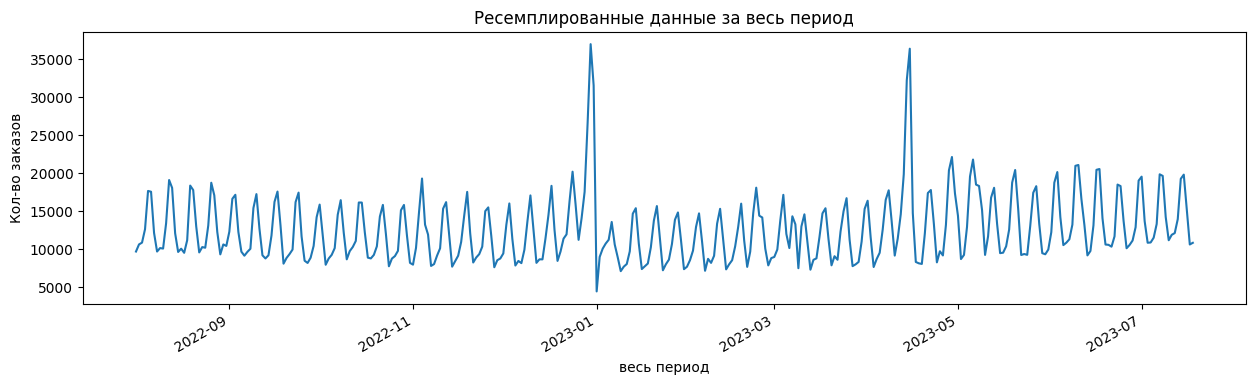

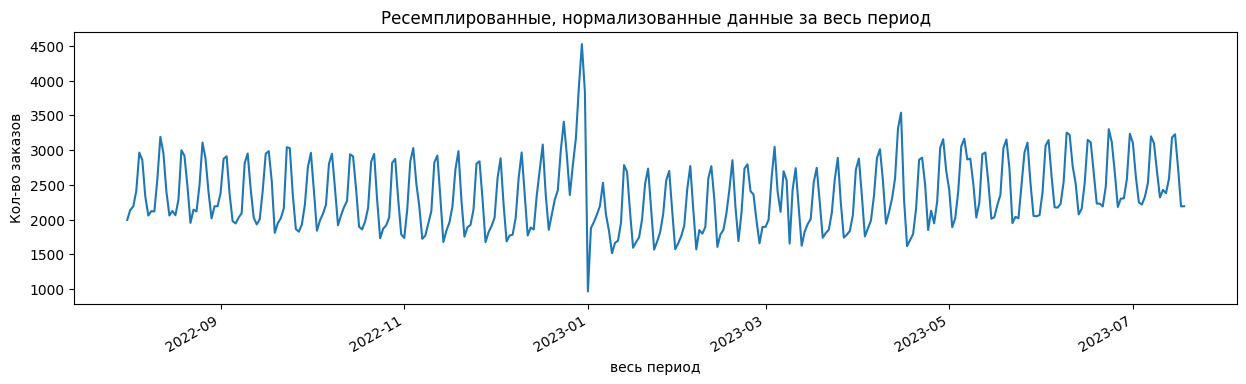

In [52]:
res_graph (activ_store['pr_sales_in_units_res'] , 'Ресемплированные данные', 'весь период')
res_graph (activ_store['pr_sales_in_units_lres'] , 'Ресемплированные, нормализованные данные', 'весь период')

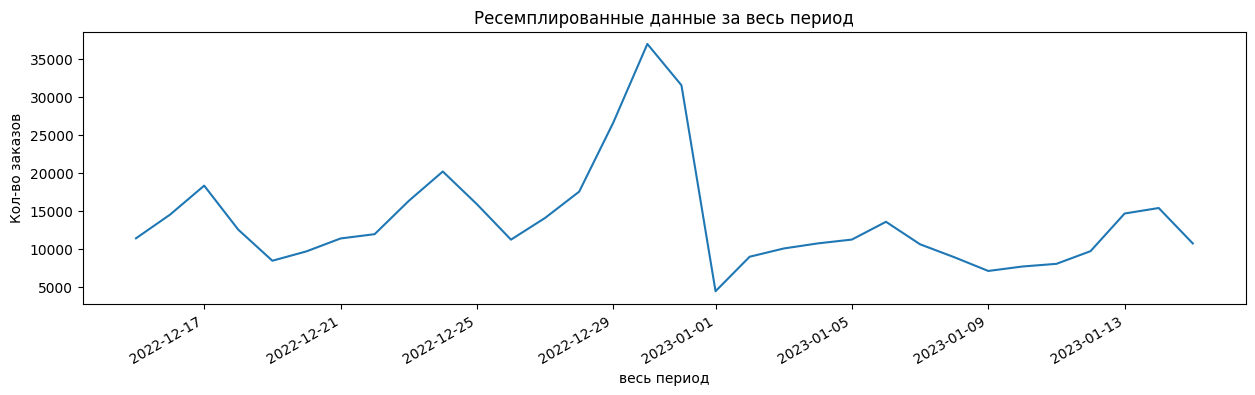

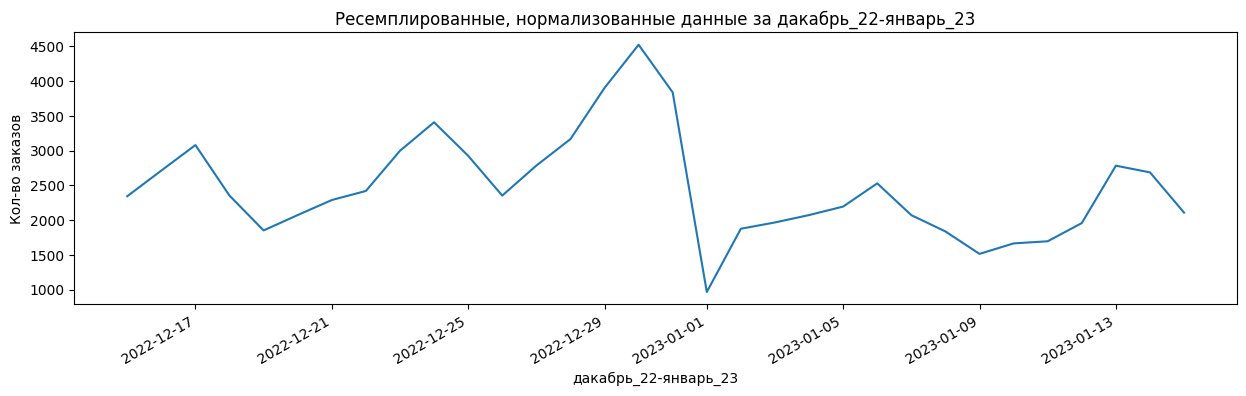

In [53]:
#res_graph (activ_store['pr_sales_in_units']['2022-12-15':'2023-01-15'], 'Ресемплированные данные', 'дакабрь_22-январь_23')
res_graph (activ_store['pr_sales_in_units_res'] ['2022-12-15':'2023-01-15'], 'Ресемплированные данные', 'весь период')
res_graph (activ_store['pr_sales_in_units_lres'] ['2022-12-15':'2023-01-15'], 'Ресемплированные, нормализованные данные', 'дакабрь_22-январь_23')

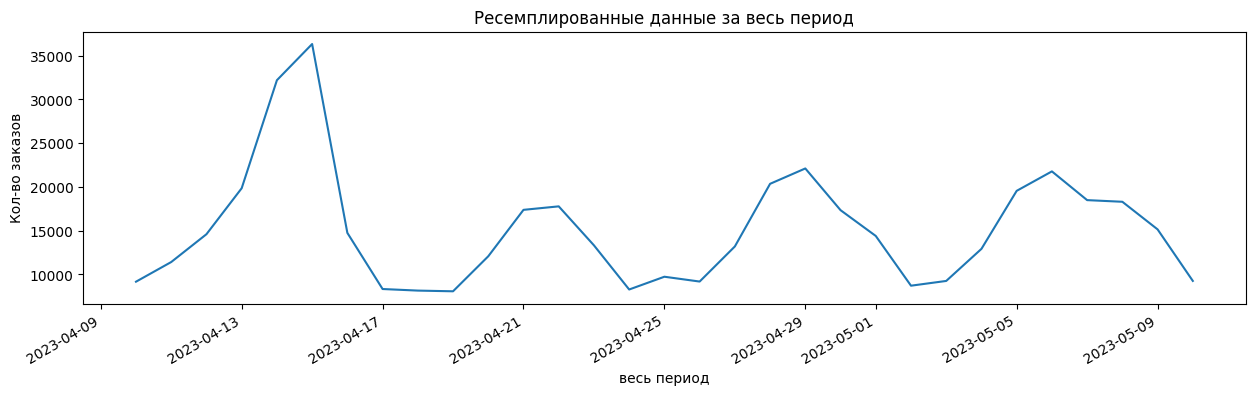

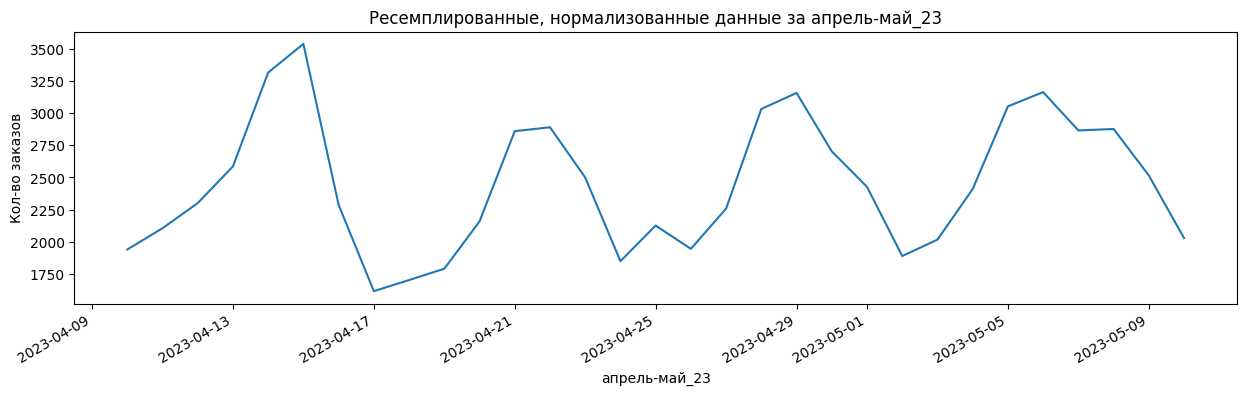

In [54]:
#res_graph (activ_store['pr_sales_in_units']['2023-04-10':'2023-05-10'], 'Ресемплированные данные', 'апрель-май_23')
res_graph (activ_store['pr_sales_in_units_res'] ['2023-04-10':'2023-05-10'], 'Ресемплированные данные', 'весь период')
res_graph (activ_store['pr_sales_in_units_lres'] ['2023-04-10':'2023-05-10'], 'Ресемплированные, нормализованные данные', 'апрель-май_23')

Вывод:
- после ресемплировании дат по сумме, наблюдается явная сезонность, самый большой всплеск продаж - в декабре, а также май, июнь, что явно совпадает с государственными праздниками.
> Явные выбросы по продажам в районе НГ (c 29 по 31 декабря), в апреле, видимо Пасха (13-15 апреля) и майских праздников (27-29 мая).
- Видим линейную зависимость общих продаж и продаж с промо.
- при подготовке датасета будем ресемплировать по дням. для более точного прогноза.

#### **Проверим сезонность**
- decomposed.trend — тренд;
- decomposed.seasonal — сезонная составляющая;
- decomposed.weights — веса, используются для уменьшения влияния выбросов.

Text(0.5, 1.0, 'Weights')

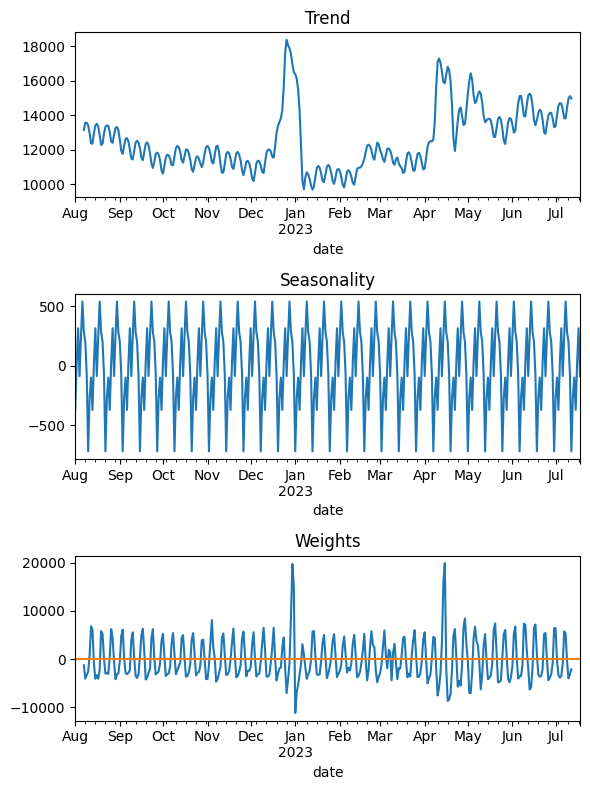

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

#data_time = activ_store['pr_sales_in_units_res'].interpolate()
decomposed = seasonal_decompose(data_d, period=12) #activ_store['pr_sales_in_units']

#decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
decomposed.weights.plot(ax=plt.gca())
plt.title('Weights')

In [56]:
def seasonal_graph(data, date1, date2):

    #data_time = data.interpolate()
    decomposed = seasonal_decompose(data, period=12)
    plt.figure(figsize=(6, 8))
    plt.subplot(411)
    decomposed.seasonal[f'{date1}':f'{date2}'].plot(ax=plt.gca()) #2018-07-02
    plt.title('Seasonality')

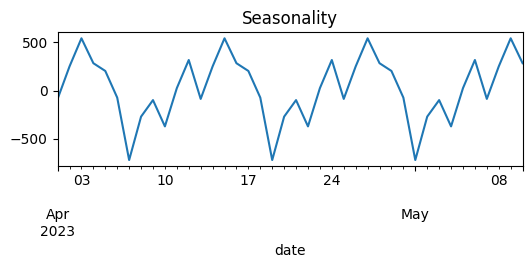

In [57]:
seasonal_graph(data_d, '2023-04-01', '2023-05-10')
#seasonal_graph(data_dl, '2023-04-01', '2023-05-10')

**Выводы:**
- Тренд ровный, совсем немного растущий вверх, но наблюдаются явные выбросы.
- При более детальном рассмотрении графика сезонности наблюдается цикличность в промежутке **2 недели**.

#### **Скользящее среднее и стандартное отклонение**
**Стационарность ряда**
Проверим на стационарность ряда.
Найдём скользящее **среднее** и  скользящее **стандартное отклонение** (англ. rolling standard deviation, rolling std) — стандартное отклонение по скользящему окну, размер окна возьмем равное 15:

In [58]:
def res_graph1 (data, name, name1, name2, name3, period, period1, period2):
    figsize = (15,4)
    data[name1][period1:period2].plot(figsize=figsize, label=name1)
    data[name2][period1:period2].plot(figsize=figsize, label=name2)
    data[name3][period1:period2].plot(figsize=figsize, label=name3)
    plt.title(f'{name} за {period}')
    plt.xlabel(f'{period}')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [59]:
activ_store.head()

,year,month,weekday,day,holiday,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,...,pr_subcat_id,pr_uom_id,st_type_format_id,st_type_loc_id,st_type_size_id,st_city_id,st_division_code,pr_sales_in_units_log,pr_sales_in_units_res,pr_sales_in_units_lres
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,1.0,5,0,79.0,79.0,...,8afe22eeb3f3f68de994a3c60388858c,1.0,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1.609438,9699,1994.558628
2022-08-01,2022,8,6,8,1,0.0,21,0,462.0,0.0,...,e06f5ed77191826c212c30722f2cc5a2,17.0,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,3.044522,9699,1994.558628
2022-08-01,2022,8,6,8,1,1.0,1,1,154.0,154.0,...,b3e70d072fc648f6934c288e44f5c35e,1.0,1.0,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,0.000000,9699,1994.558628
2022-08-01,2022,8,6,8,1,0.0,6,0,860.0,0.0,...,c01c475ac8d447730ece97d846cc4f25,1.0,1.0,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1.791759,9699,1994.558628
2022-08-01,2022,8,6,8,1,1.0,1,1,57.0,57.0,...,89b0107c6d0aca5f15fa7a715f9e06e5,1.0,1.0,1.0,12.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,0.000000,9699,1994.558628


In [60]:
activ_store['pr_sales_in_units_res'] = activ_store['pr_sales_in_units'].resample('1D').sum()

In [61]:
activ_store['mean'] = activ_store['pr_sales_in_units_res'].rolling(15).mean()
activ_store['std'] = activ_store['pr_sales_in_units_res'].rolling(15).std()

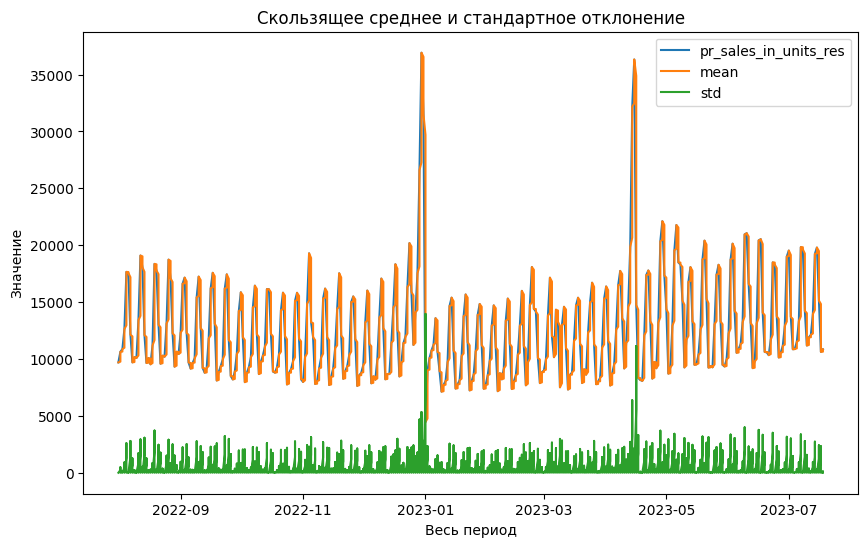

In [62]:
#res_graph (activ_store['pr_sales_in_units_res', 'mean', 'std'], 'Скользящее среднее и стандартное отклонение', 'весь период')
plt.figure(figsize=(10, 6))
plt.plot(activ_store.index, activ_store['pr_sales_in_units_res'], label='pr_sales_in_units_res')
plt.plot(activ_store.index, activ_store['mean'], label='mean')
plt.plot(activ_store.index, activ_store['std'], label='std')
plt.title('Скользящее среднее и стандартное отклонение')
plt.xlabel('Весь период')
plt.ylabel('Значение')
plt.legend()
plt.show()

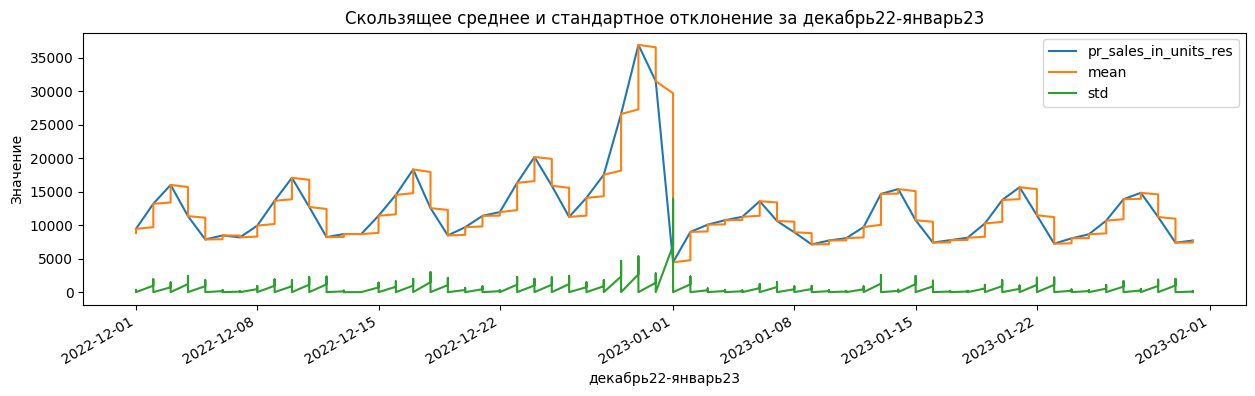

In [63]:
res_graph1 (activ_store, 'Скользящее среднее и стандартное отклонение', \
            'pr_sales_in_units_res', 'mean', 'std','декабрь22-январь23', '2022-12-01','2023-01-31')

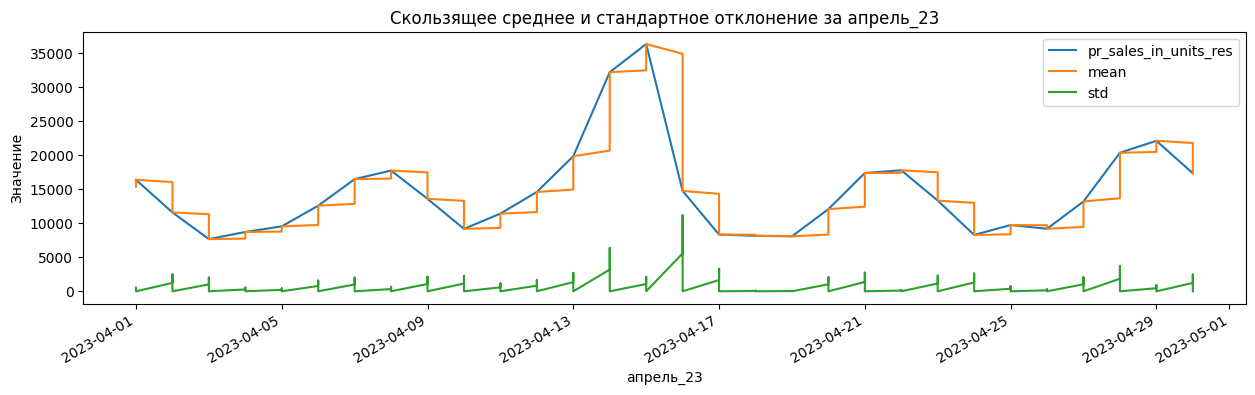

In [64]:
res_graph1 (activ_store, 'Скользящее среднее и стандартное отклонение', \
            'pr_sales_in_units_res', 'mean', 'std','апрель_23', '2023-04-01','2023-04-30')

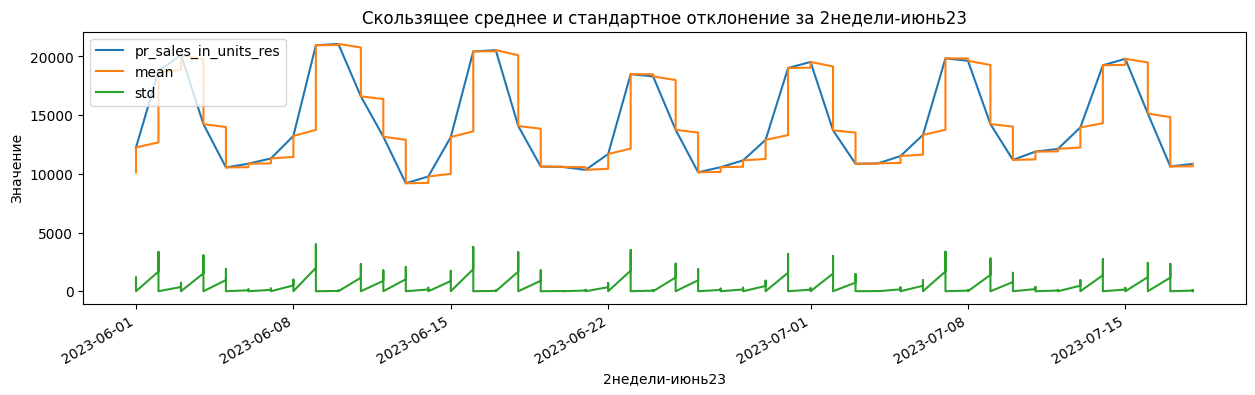

In [65]:
res_graph1 (activ_store, 'Скользящее среднее и стандартное отклонение', \
            'pr_sales_in_units_res', 'mean', 'std','2недели-июнь23', '2023-06-01','2023-08-15')

## **Создадим дополнительные признаки:**
- установим в признаке `pr_uom_id`  маркеры товаров продающихся поштучно = 1, на вес = 0.
- доля промо продаж `'promo_part'`
- цена за единицу товара `price_units`
- в календарь праздников добавим `month`


In [66]:
# маркер товаров продающихся по штучно = 1, на вес = 0
activ_store['pr_uom_id'] = activ_store['pr_uom_id'].apply(lambda x: 0 if x != 1 else x)
express_info(activ_store, 'данных по объедененному датасету')

Информация данных по объедененному датасету:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813034 entries, 2022-08-01 to 2023-07-18
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   year                     813034 non-null  int64  
 1   month                    813034 non-null  int64  
 2   weekday                  813034 non-null  int64  
 3   day                      813034 non-null  int64  
 4   holiday                  813034 non-null  int64  
 5   pr_sales_type_id         813034 non-null  float64
 6   pr_sales_in_units        813034 non-null  int64  
 7   pr_promo_sales_in_units  813034 non-null  int64  
 8   pr_sales_in_rub          813034 non-null  float64
 9   pr_promo_sales_in_rub    813034 non-null  float64
 10  st_id                    813034 non-null  object 
 11  pr_sku_id                813034 non-null  object 
 12  pr_group_id              813034 non-null  object 
 13

,year,month,weekday,day,holiday,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,...,st_type_format_id,st_type_loc_id,st_type_size_id,st_city_id,st_division_code,pr_sales_in_units_log,pr_sales_in_units_res,pr_sales_in_units_lres,mean,std
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,1.0,5,0,79.0,79.0,...,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1.609438,9699,1994.558628,NaN,NaN
2022-08-01,2022,8,6,8,1,0.0,21,0,462.0,0.0,...,1.0,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,3.044522,9699,1994.558628,NaN,NaN
2022-08-01,2022,8,6,8,1,1.0,1,1,154.0,154.0,...,1.0,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,0.000000,9699,1994.558628,NaN,NaN
2022-08-01,2022,8,6,8,1,0.0,6,0,860.0,0.0,...,1.0,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1.791759,9699,1994.558628,NaN,NaN
2022-08-01,2022,8,6,8,1,1.0,1,1,57.0,57.0,...,1.0,1.0,12.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,0.000000,9699,1994.558628,NaN,NaN


### **Анализ продаж по товарам**

In [67]:
# сделаем группировку и агрегацию по товарам
grouped = activ_store.groupby('pr_sku_id')
sales_type = grouped[['pr_sales_in_units', 'pr_promo_sales_in_units']].agg(['sum'])
# сортировака по сумме
sales_type_sorted = sales_type.sort_values(by=('pr_sales_in_units', 'sum'), ascending=False)
sales_type_sorted.head()

,pr_sales_in_units,pr_promo_sales_in_units
,sum,sum
pr_sku_id,,
62d4af457ba2540ce0898a211c0cd17a,115224,19570
ced0c1a84924c982a6403870c54b99ca,112655,38368
c0e3f3bd815a862433bc3399c487926b,109280,20803
4b083e10f6cd2f4360c5425d05be6386,82704,68826
d5bfeecaaa47887a4b92d17fa55c2e18,75305,10070


In [68]:
# добавим столбец с долей товаров с промо
sales_type_sorted['promo_part'] = ((sales_type_sorted[('pr_promo_sales_in_units', 'sum')]\
                                    / sales_type_sorted[('pr_sales_in_units', 'sum')])).round(3)
sales_type_sorted.head()

,pr_sales_in_units,pr_promo_sales_in_units,promo_part
,sum,sum,
pr_sku_id,,,
62d4af457ba2540ce0898a211c0cd17a,115224,19570,0.170
ced0c1a84924c982a6403870c54b99ca,112655,38368,0.341
c0e3f3bd815a862433bc3399c487926b,109280,20803,0.190
4b083e10f6cd2f4360c5425d05be6386,82704,68826,0.832
d5bfeecaaa47887a4b92d17fa55c2e18,75305,10070,0.134


#### Добавим долю продаж промо в таблицу activ_store

In [69]:
# сгруппируем таблицу sales_type_sorted
aggregated_sales_type = sales_type_sorted.groupby('pr_sku_id')['promo_part'].first().reset_index()

# добавим столбец 'promo_part' в таблицу activ_store
activ_store['promo_part'] = activ_store['pr_sku_id'].map(aggregated_sales_type.set_index('pr_sku_id')['promo_part'])
activ_store.head()

,year,month,weekday,day,holiday,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,...,st_type_loc_id,st_type_size_id,st_city_id,st_division_code,pr_sales_in_units_log,pr_sales_in_units_res,pr_sales_in_units_lres,mean,std,promo_part
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,1.0,5,0,79.0,79.0,...,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1.609438,9699,1994.558628,NaN,NaN,0.060
2022-08-01,2022,8,6,8,1,0.0,21,0,462.0,0.0,...,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,3.044522,9699,1994.558628,NaN,NaN,0.200
2022-08-01,2022,8,6,8,1,1.0,1,1,154.0,154.0,...,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,0.000000,9699,1994.558628,NaN,NaN,0.357
2022-08-01,2022,8,6,8,1,0.0,6,0,860.0,0.0,...,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1.791759,9699,1994.558628,NaN,NaN,0.408
2022-08-01,2022,8,6,8,1,1.0,1,1,57.0,57.0,...,1.0,12.0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,0.000000,9699,1994.558628,NaN,NaN,0.124


In [70]:
# сортируем по столбцу 'promo_part' в порядке убывания
promo_part_type_sorted = sales_type_sorted.sort_values(by='promo_part', ascending=False)
promo_part_type_sorted.head()

,pr_sales_in_units,pr_promo_sales_in_units,promo_part
,sum,sum,
pr_sku_id,,,
e0a043194cdf8a069ea2f260b51ea222,10,10,1.0
4b720d804b03d973b2888fdb874c5670,8,8,1.0
8a83012840a59f8e2edf61d9f7a38982,41,41,1.0
27fcd3eab94dfa545d11f263e2bcb6a0,13,13,1.0
bd286184ea27adbc9b2a9cfced119e9d,39,39,1.0


####Типы продаж

In [71]:
# товары с промо
pr_sales_type_id = activ_store[activ_store['pr_sales_type_id'] != 1]
print('Количество проданных типов товаров с промо', pr_sales_type_id['pr_sales_type_id'].count())

Количество проданных типов товаров с промо 482971


Оставим товары, которые продавались без промо

In [72]:
# удалим строки с промо, но те у которых есть продажи без промо
condition = (activ_store['pr_sales_type_id'] == 1)\
            & (activ_store['pr_sku_id'].isin(activ_store.loc[activ_store['pr_sales_type_id'] == 0, 'pr_sku_id']))

activ_store = activ_store[~condition]

# удалим столбцы
activ_store = activ_store.drop(['pr_sales_type_id', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1)
activ_store.head()

,year,month,weekday,day,holiday,pr_sales_in_units,pr_sales_in_rub,st_id,pr_sku_id,pr_group_id,...,st_type_loc_id,st_type_size_id,st_city_id,st_division_code,pr_sales_in_units_log,pr_sales_in_units_res,pr_sales_in_units_lres,mean,std,promo_part
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,21,462.0,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,c74d97b01eae257e44aa9d5bade97baf,...,1.0,8.0,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,3.044522,9699,1994.558628,NaN,NaN,0.200
2022-08-01,2022,8,6,8,1,6,860.0,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,aab3238922bcc25a6f606eb525ffdc56,...,1.0,12.0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1.791759,9699,1994.558628,NaN,NaN,0.408
2022-08-01,2022,8,6,8,1,1,65.0,16a5cdae362b8d27a1d8f8c7b78b4330,3f33017a9ce4fbff701facaeae7a7549,c74d97b01eae257e44aa9d5bade97baf,...,2.0,8.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,0.000000,9699,1994.558628,NaN,NaN,0.202
2022-08-01,2022,8,6,8,1,17,1012.0,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6d8bf88f6daf3b37de081afcf75ec6cf,c74d97b01eae257e44aa9d5bade97baf,...,1.0,12.0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,2.833213,9699,1994.558628,NaN,NaN,0.423
2022-08-01,2022,8,6,8,1,1,214.0,16a5cdae362b8d27a1d8f8c7b78b4330,517b5edeb76505d48bb945abce481959,aab3238922bcc25a6f606eb525ffdc56,...,2.0,8.0,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,0.000000,9699,1994.558628,NaN,NaN,0.342


Вывод:
- Мы видим, что ряд продаж товаров `pr_sales_in_units` совпадает полностью `pr_promo_sales_in_units`.
- Добавили в общую таблицу признак доля продаж промо `promo_part`.
- удалили `'pr_sales_type_id', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub'`, так как в итоге они стали неинформативными.
- оставили товары, которые продавались без промо.
- удалили неявные дубликаты продаж, где одноременно были продажи товаров с промо и без.

### **Посчитаем цены**
  - Стоимость одного товара (за день)
  - Стоимость группы товаров (за день)

In [73]:
# цена за единицу товара
activ_store['price_units'] = (activ_store['pr_sales_in_rub'] / activ_store['pr_sales_in_units']).round(2)
activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483227 entries, 2022-08-01 to 2023-07-18
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   year                    483227 non-null  int64  
 1   month                   483227 non-null  int64  
 2   weekday                 483227 non-null  int64  
 3   day                     483227 non-null  int64  
 4   holiday                 483227 non-null  int64  
 5   pr_sales_in_units       483227 non-null  int64  
 6   pr_sales_in_rub         483227 non-null  float64
 7   st_id                   483227 non-null  object 
 8   pr_sku_id               483227 non-null  object 
 9   pr_group_id             483227 non-null  object 
 10  pr_cat_id               483227 non-null  object 
 11  pr_subcat_id            483227 non-null  object 
 12  pr_uom_id               483227 non-null  float64
 13  st_type_format_id       483227 non-null  float64
 14  st_t

In [74]:
# товары в единицах по категориям
activ_store_cat=activ_store.groupby('pr_group_id').pr_sales_in_units.agg(['sum']).sort_values(by=('sum'), ascending=False)
activ_store_cat

,sum
pr_group_id,
c74d97b01eae257e44aa9d5bade97baf,1318299
aab3238922bcc25a6f606eb525ffdc56,721908
6512bd43d9caa6e02c990b0a82652dca,231429
c20ad4d76fe97759aa27a0c99bff6710,105865
c51ce410c124a10e0db5e4b97fc2af39,62414
1ff1de774005f8da13f42943881c655f,8848
32bb90e8976aab5298d5da10fe66f21d,7331
98f13708210194c475687be6106a3b84,390
3c59dc048e8850243be8079a5c74d079,28


In [75]:
# товары в единицах по магазинам
activ_store.groupby('st_id').pr_sales_in_units.agg(['sum']).sort_values(by=('sum'), ascending=False)

,sum
st_id,
c81e728d9d4c2f636f067f89cc14862c,525368
16a5cdae362b8d27a1d8f8c7b78b4330,508079
f7e6c85504ce6e82442c770f7c8606f0,386257
42a0e188f5033bc65bf8d78622277c4e,375902
fa7cdfad1a5aaf8370ebeda47a1ff1c3,303640
6364d3f0f495b6ab9dcf8d3b5c6e0b01,272606
1ecfb463472ec9115b10c292ef8bc986,74338
53e19f3dbb211f20b20b45668303c1b6,8687
bd470ca955d9497bbcb808e59952fffc,1635


In [76]:
# стандартизируем продажи в штуках промо
pr_sales_in_units_mean = activ_store.pr_sales_in_units.mean()
pr_sales_in_units_sd = activ_store.pr_sales_in_units.std()

activ_store['pr_sales_in_units_stand'] = (activ_store.pr_sales_in_units - pr_sales_in_units_mean) / pr_sales_in_units_sd

In [77]:
# стандартизируем продажи в рублях за штуку, в дальнейшем проверим работу модели на них
price_units_mean = activ_store.price_units.mean()
price_units_sd = activ_store.price_units.std()
activ_store['price_units_stand'] = (activ_store.price_units - price_units_mean) / price_units_sd

In [78]:
# удалим столбец стоимость товара в рублях, так как дублирует целевой признак
activ_store = activ_store.drop(['pr_sales_in_rub'] , axis=1)

Вывод:
- создали новый признак  по прадажам в рублях за единицу товара`'price_units'`, затем стандартизировали его.
- удалили `'pr_sales_in_rub'`
- создали новые признаки по продажам с промо и без промо `'pr_sales_in_units_stand'`, `'price_units_stand'` - стандартизировав исходные.

#### **Продажи по типам магазинов**

st_type_format_id      st_type_format_id
1.0           0.939095
2.0           0.051044
4.0           0.009861


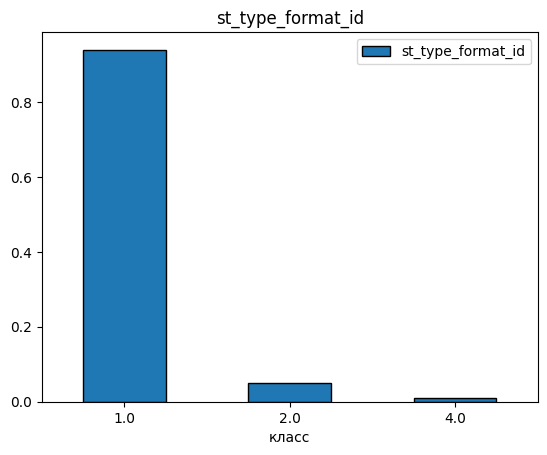

st_type_loc_id      st_type_loc_id
1.0        0.803898
2.0        0.186242
3.0        0.009861


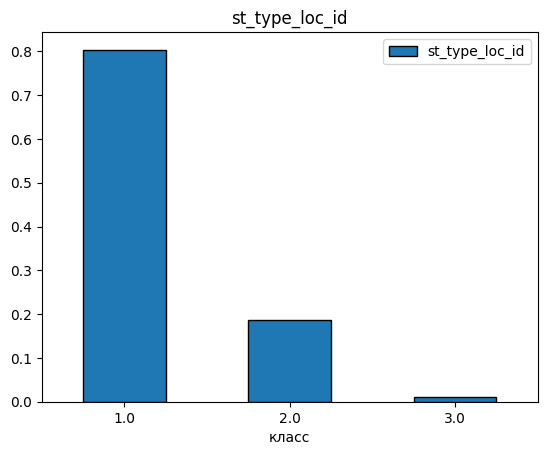

st_type_size_id       st_type_size_id
12.0         0.565600
8.0          0.373495
28.0         0.051044
20.0         0.008098
19.0         0.001763


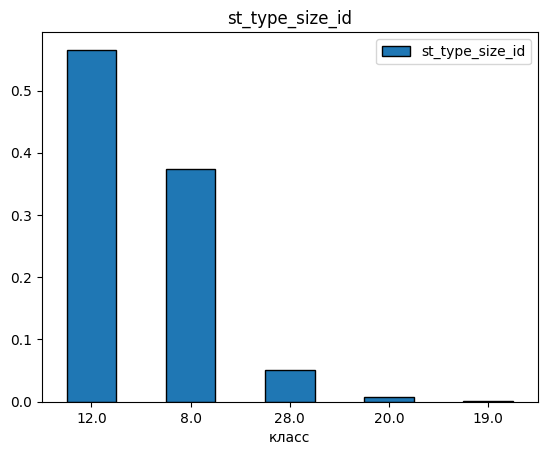

pr_uom_id      pr_uom_id
1.0   0.619208
0.0   0.380792


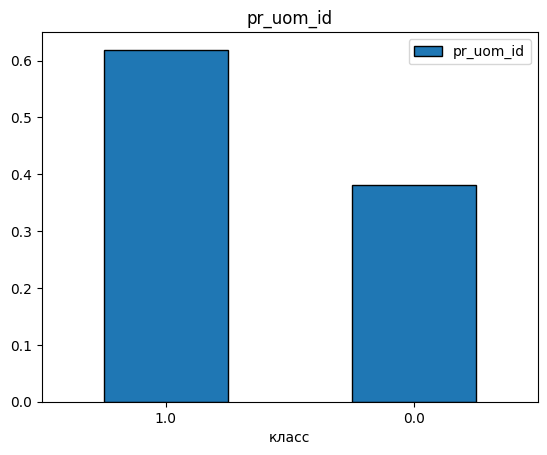

In [79]:
type_graph_list = ['st_type_format_id', 'st_type_loc_id', 'st_type_size_id','pr_uom_id']
for column in type_graph_list:
    class_frequency = activ_store[column].value_counts(normalize= True).to_frame()
    print(f'{column}',class_frequency)
    ax = class_frequency.plot(kind='bar', rot=0, edgecolor='black', linewidth=1)
    ax.set_xlabel('класс')
    ax.set_title(f'{column}')
    plt.show()

In [80]:
# сделаем группировку и агрегацию по форматам магазинов
grouped = activ_store.groupby('st_type_format_id')
st_type_format = grouped[['pr_sales_in_units', 'price_units']].agg(['sum'])
# сорртировака по сумме
st_type_format_sorted = st_type_format.sort_values(by=('pr_sales_in_units', 'sum'), ascending=False)
st_type_format_sorted

,pr_sales_in_units,price_units
,sum,sum
st_type_format_id,,
1.0,2371852,62921198.24
2.0,74338,2162577.28
4.0,10322,321987.83


In [81]:
# сделаем группировку и агрегацию по локациям магазинов
grouped = activ_store.groupby('st_type_loc_id')
st_type_loc = grouped[['pr_sales_in_units', 'price_units']].agg(['sum'])
# сорртировака по сумме
st_type_loc_sorted = st_type_loc.sort_values(by=('pr_sales_in_units', 'sum'), ascending=False)
st_type_loc_sorted

,pr_sales_in_units,price_units
,sum,sum
st_type_loc_id,,
1.0,1938111,52982332.85
2.0,508079,12101442.67
3.0,10322,321987.83


In [82]:
# сделаем группировку и агрегацию по размерам магазинов
grouped = activ_store.groupby('st_type_size_id')
st_type_size = grouped[['pr_sales_in_units', 'price_units']].agg(['sum'])
# сорртировака по сумме
st_type_size_sorted = st_type_size.sort_values(by=('pr_sales_in_units', 'sum'), ascending=False)
st_type_size_sorted

,pr_sales_in_units,price_units
,sum,sum
st_type_size_id,,
12.0,1338405,37414537.14
8.0,1033447,25506661.10
28.0,74338,2162577.28
20.0,8687,269246.82
19.0,1635,52741.01


In [83]:
#Создадим новые признаки по магазинам
columns_to_process = ['st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_division_code', 'st_city_id']

for column in columns_to_process:
    # количество уникальных товаров в типе магазина
    type_unique_counts = activ_store.groupby(column)['pr_sku_id'].nunique().sort_values()

    #сумма продаж по типам магазина
    type_sales_sum = activ_store.groupby(column)['pr_sales_in_units'].sum()

    # доля продаж уникальных товаров в типе магазина
    sku_sales_share_in_type = type_unique_counts / type_sales_sum

    # добавим доли продаж в таблицу
    activ_store[f'sku_sales_share_in_{column}'] = activ_store[column].map(sku_sales_share_in_type)

In [84]:
activ_store.head()

,year,month,weekday,day,holiday,pr_sales_in_units,st_id,pr_sku_id,pr_group_id,pr_cat_id,...,std,promo_part,price_units,pr_sales_in_units_stand,price_units_stand,sku_sales_share_in_st_type_format_id,sku_sales_share_in_st_type_loc_id,sku_sales_share_in_st_type_size_id,sku_sales_share_in_st_division_code,sku_sales_share_in_st_city_id
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,21,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,...,NaN,0.200,22.00,1.478838,-0.901789,0.000742,0.000945,0.001268,0.001988,0.001988
2022-08-01,2022,8,6,8,1,6,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,...,NaN,0.408,143.33,0.085149,0.063470,0.000742,0.000945,0.001056,0.001670,0.001670
2022-08-01,2022,8,6,8,1,1,16a5cdae362b8d27a1d8f8c7b78b4330,3f33017a9ce4fbff701facaeae7a7549,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,...,NaN,0.202,65.00,-0.379414,-0.559696,0.000742,0.001838,0.001268,0.001253,0.001838
2022-08-01,2022,8,6,8,1,17,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6d8bf88f6daf3b37de081afcf75ec6cf,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,...,NaN,0.423,59.53,1.107188,-0.603214,0.000742,0.000945,0.001056,0.001253,0.002602
2022-08-01,2022,8,6,8,1,1,16a5cdae362b8d27a1d8f8c7b78b4330,517b5edeb76505d48bb945abce481959,aab3238922bcc25a6f606eb525ffdc56,186a157b2992e7daed3677ce8e9fe40f,...,NaN,0.342,214.00,-0.379414,0.625696,0.000742,0.001838,0.001268,0.001253,0.001838


Вывод:
- проанализировали доли продаж в разных типах и размерах магазинов;
- установили в признаке `pr_uom_id`  маркеры товаров продающихся поштучно = 1, на вес = 0.
- добавили признаки долей продаж по типам, форматам и локациям магазинов: `sku_sales_share_in_st_type_format_id,	sku_sales_share_in_st_type_loc_id,	sku_sales_share_in_st_type_size_id,sku_sales_share_in_st_division_code,	sku_sales_share_in_st_city_id`

#### Категории товаров

In [85]:
# сделаем группировку и агрегацию по подкатегориям
grouped = activ_store.groupby('pr_subcat_id')
pr_subcat_id = grouped[['pr_sales_in_units', 'price_units']].agg(['sum'])
# сорртировака по сумме
pr_subcat_id_sorted = pr_subcat_id.sort_values(by=('pr_sales_in_units', 'sum'), ascending=False)
pr_subcat_id_sorted.head(10)

,pr_sales_in_units,price_units
,sum,sum
pr_subcat_id,,
e06f5ed77191826c212c30722f2cc5a2,301135,913556.11
aa36dc1d45661519a5bf923429776a83,133884,2005650.73
130d817d8b3f616e97c555ec57946aec,113128,415449.39
1e2248e0a1305fdf1dca5510e06a2b96,94353,381485.72
6e84696301885ba0a9dc8de6fe45abd0,84562,287121.58
c93c26cd49ea08e6b8984351d4164575,76068,1606242.86
1507fc0175c1ff0cf4440105bc6f93e6,65609,242114.98
0f3abfd67959c079e7b3759440e7415c,57656,1479125.13


In [86]:
# доля продаж товаров в подкатегории
#activ_store['sales_part_in_subcat'] = activ_store\
#                                     .groupby(['pr_subcat_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x / x.sum())

#### Группы товаров

In [87]:
# сделаем группировку и агрегацию по группам
grouped = activ_store.groupby('pr_group_id')
group_id = grouped[['pr_sales_in_units', 'price_units']].agg(['sum'])
# сорртировака по сумме
group_id_sorted = group_id.sort_values(by=('pr_sales_in_units', 'sum'), ascending=False)
group_id_sorted

,pr_sales_in_units,price_units
,sum,sum
pr_group_id,,
c74d97b01eae257e44aa9d5bade97baf,1318299,16680776.26
aab3238922bcc25a6f606eb525ffdc56,721908,31181475.35
6512bd43d9caa6e02c990b0a82652dca,231429,6982058.30
c20ad4d76fe97759aa27a0c99bff6710,105865,2112548.25
c51ce410c124a10e0db5e4b97fc2af39,62414,6947809.63
1ff1de774005f8da13f42943881c655f,8848,744809.99
32bb90e8976aab5298d5da10fe66f21d,7331,736600.84
98f13708210194c475687be6106a3b84,390,19072.33


In [88]:
# доля продаж товара в группе
#activ_store['sales_part_in_group'] = activ_store.groupby(['pr_group_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x / x.sum())

In [89]:
columns_to_process = ['pr_group_id', 'pr_cat_id', 'pr_subcat_id']

for column in columns_to_process:
    # количество уникальных товаров в каждой категории
    cat_unique_counts = activ_store.groupby(column)['pr_sku_id'].nunique().sort_values()

    # сумма продаж для каждой категории
    cat_sales_sum = activ_store.groupby(column)['pr_sales_in_units'].sum()

    # для продаж уникальных товаров в каждой категории
    sku_sales_share_in_cat = cat_unique_counts / cat_sales_sum

    # для продаж уникальных товаров в таблицу
    activ_store[f'sales_share_in_{column}'] = activ_store[column].map(sku_sales_share_in_cat)

In [90]:
activ_store = activ_store.drop(['pr_group_id', 'pr_cat_id', 'pr_subcat_id', \
                                'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_division_code', 'st_city_id'], axis=1)

In [91]:
activ_store.head(3)

,year,month,weekday,day,holiday,pr_sales_in_units,st_id,pr_sku_id,pr_uom_id,pr_sales_in_units_log,...,pr_sales_in_units_stand,price_units_stand,sku_sales_share_in_st_type_format_id,sku_sales_share_in_st_type_loc_id,sku_sales_share_in_st_type_size_id,sku_sales_share_in_st_division_code,sku_sales_share_in_st_city_id,sales_share_in_pr_group_id,sales_share_in_pr_cat_id,sales_share_in_pr_subcat_id
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,2022,8,6,8,1,21,c81e728d9d4c2f636f067f89cc14862c,a26de72f8ea9889b7332ed5f940d8b62,0.0,3.044522,...,1.478838,-0.901789,0.000742,0.000945,0.001268,0.001988,0.001988,0.000575,0.000294,0.000110
2022-08-01,2022,8,6,8,1,6,42a0e188f5033bc65bf8d78622277c4e,dce1f234d6424aa61f8e7ce0baffd9af,1.0,1.791759,...,0.085149,0.063470,0.000742,0.000945,0.001056,0.001670,0.001670,0.000978,0.001183,0.001283
2022-08-01,2022,8,6,8,1,1,16a5cdae362b8d27a1d8f8c7b78b4330,3f33017a9ce4fbff701facaeae7a7549,0.0,0.000000,...,-0.379414,-0.559696,0.000742,0.001838,0.001268,0.001253,0.001838,0.000575,0.000735,0.000768


**Вывод:**
Добавили признаки:
- доля продаж товаров в подкатегории `sales_share_in_pr_subcat_id`
- доля продаж товара в группе `sales_share_in_pr_group_id`
- доля продаж товаров в категории	`sales_share_in_pr_cat_id`
- удалили неинформативные признаки `'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_division_code', 'st_city_id'`.

### **Построим корреляционную матрицу для смешанного набора признаков**

In [92]:
#напишем функию для исследования данных
def research1(data, name, figsize, silent): #, interval_cols
    print(f'Размер данных:      {data.shape}')
    if not silent:
        print(f'Количество явных дубликатов: {data.duplicated().sum()}')
        print(f'Наличие пропусков:           {data.isna().sum().sum()}')
        data.info()
    if silent:
        data.columns
        #тепловая карта корреляций
        phik_overview = data.phik_matrix() #interval_cols=interval_cols
        plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='coolwarm',
                        title=f"Корреляция {name} $\phi_K$",
                        fontsize_factor=1,
                        figsize=(12, 7))
        plt.tight_layout()

In [93]:
research1(activ_store, 'данных', figsize=(23, 17), silent=False)

Размер данных:      (483227, 26)
Количество явных дубликатов: 0
Наличие пропусков:           16
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483227 entries, 2022-08-01 to 2023-07-18
Data columns (total 26 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   year                                  483227 non-null  int64  
 1   month                                 483227 non-null  int64  
 2   weekday                               483227 non-null  int64  
 3   day                                   483227 non-null  int64  
 4   holiday                               483227 non-null  int64  
 5   pr_sales_in_units                     483227 non-null  int64  
 6   st_id                                 483227 non-null  object 
 7   pr_sku_id                             483227 non-null  object 
 8   pr_uom_id                             483227 non-null  float64
 9   pr_sales_in_units_log   

Размер данных:      (483227, 26)
interval columns not set, guessing: ['year', 'month', 'weekday', 'day', 'holiday', 'pr_sales_in_units', 'pr_uom_id', 'pr_sales_in_units_log', 'pr_sales_in_units_res', 'pr_sales_in_units_lres', 'mean', 'std', 'promo_part', 'price_units', 'pr_sales_in_units_stand', 'price_units_stand', 'sku_sales_share_in_st_type_format_id', 'sku_sales_share_in_st_type_loc_id', 'sku_sales_share_in_st_type_size_id', 'sku_sales_share_in_st_division_code', 'sku_sales_share_in_st_city_id', 'sales_share_in_pr_group_id', 'sales_share_in_pr_cat_id', 'sales_share_in_pr_subcat_id']


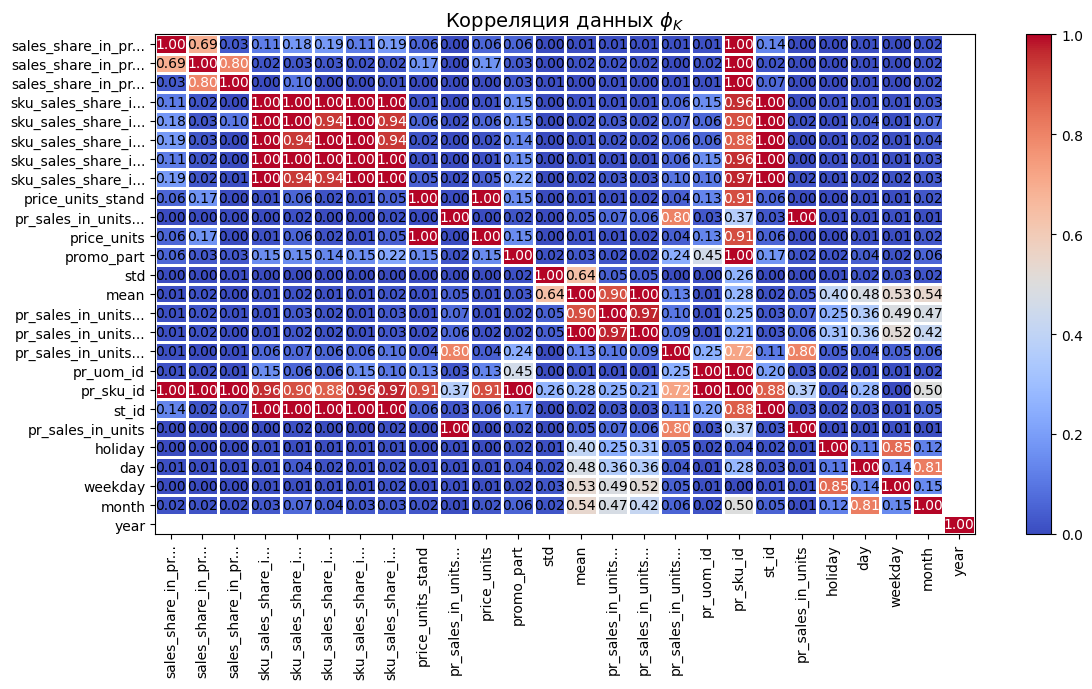

In [94]:
research1(activ_store, 'данных', figsize=(23, 17), silent=True)

In [95]:
#interval_cols = activ_store.columns.tolist()
#phik_matrix = activ_store.phik_matrix(interval_cols=interval_cols)

#plt.figure(figsize=(10, 8))
#sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, fmt=".2f")
#plt.title('Матрица корреляции')
#plt.show()

## **Построение модели**

> **применим модель ORBIT**


Выбираем магазин с наибольшим количеством продаж
`'c81e728d9d4c2f636f067f89cc14862c'`

In [108]:
#Выбираем магазин с наибольшим количеством продаж
activ_store[activ_store['st_id'] == 'c81e728d9d4c2f636f067f89cc14862c']
#Выбираем один из наиболее популярнах продуктов
#f = df[df['pr_sku_id'] == '6b1344097385a42484abd4746371e416']
st_id = 'c81e728d9d4c2f636f067f89cc14862c'
pr_sku_id = '6b1344097385a42484abd4746371e416'

In [97]:
df = activ_store.copy()

In [98]:
#Создадим функцию обучения и тестирования модели
# st_id - магазин
# pr_sku_id - товар
def make_predict_test(df, st_id, pr_sku_id):
    sku_st = df[(df['st_id'] == st_id) & (df['pr_sku_id'] == pr_sku_id)]
    df = sku_st.reset_index()

    train_df = df[df['date'] < '2023-07-05']
    test_df = df[df['date'] >= '2023-07-05']

    dlt = DLT(
    response_col='pr_sales_in_units_stand',
    date_col='date',
    estimator='stan-mcmc',
    seasonality=7,
    global_trend_option='loglinear',
    regressor_col=['price_units_stand', 'holiday'],
    regressor_sign=['-', '+'],
    num_warmup=10000,
    num_sample=10000
)

    dlt.fit(train_df)
    predicted_df = dlt.predict(df=train_df, decompose=True)
    predicted_df = dlt.predict(df=test_df, decompose=True)

    result_df = predicted_df[['date', 'prediction_5', 'prediction', 'prediction_95']].merge(test_df[['date', 'pr_sales_in_units_stand']], on='date', how='inner')

    result_df[['prediction_5', 'prediction', 'prediction_95', 'pr_sales_in_units']] = (result_df[['prediction_5', 'prediction', 'prediction_95', 'pr_sales_in_units_stand']] \
                            .apply(lambda x: (x * pr_sales_in_units_sd) + pr_sales_in_units_mean)).round()

    result_df['wape'] = result_df.apply(lambda row: np.sum(np.abs(row['pr_sales_in_units'] - row['prediction'])) / np.sum(np.abs(row['pr_sales_in_units'])), axis=1)
    average_wape = result_df['wape'].mean()
    print(f"Среднее значение WAPE: {average_wape}")

    result_df = result_df.drop(['pr_sales_in_units_stand'] , axis=1)

    pred_df = result_df[['date', 'pr_sales_in_units', 'prediction']]

    pred_sales_submission = pred_df.merge(df[['st_id', 'pr_sku_id']], left_index=True, right_index=True)
    pred_sales_submission = pred_sales_submission.assign(st_id=st_id, pr_sku_id=pr_sku_id)
    pred_sales_submission = pred_sales_submission[['st_id', 'pr_sku_id', 'date', 'prediction', 'pr_sales_in_units' ]]

    return pred_sales_submission, dlt


Проверяем работу функции по 1 магазину, с самыми большими продажами, и 1 виду одного из наиболее популярных товаров

In [99]:
pred_sales_submission, model_dlt = make_predict_test(df, 'c81e728d9d4c2f636f067f89cc14862c', '6b1344097385a42484abd4746371e416')

2023-10-04 11:28:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
2023-10-04 11:28:36 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.
INFO:orbit:First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Среднее значение WAPE: 0.16624271276016125


In [102]:
pred_sales_submission

,st_id,pr_sku_id,date,prediction,pr_sales_in_units
0,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-05,16.0,18.0
1,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-06,15.0,18.0
2,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-07,14.0,16.0
3,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-08,15.0,10.0
4,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-09,14.0,14.0
5,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-10,16.0,16.0
6,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-11,14.0,18.0
7,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-12,15.0,15.0
8,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-13,15.0,14.0
9,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-14,13.0,16.0


### **Исследование значимости признаков лучшей модели**

In [103]:
def graph_features (model, features, name):
    feature_importance = pd.DataFrame((model), list(features.columns),columns=['Значения'])\
                                        .reset_index().rename(columns={'index':'Признаки'})
    plt.figure(figsize=(10, 3))
    sns.barplot(x="Значения", y="Признаки", data=feature_importance.sort_values(by="Значения", ascending=False), palette = 'tab20')#'Pastel2','rainbow'
    plt.title(f'Оценка важности признаков {name}')
    plt.tight_layout()
    plt.show()

In [104]:
# создаем словарь, где ключ - это магазин, а значения - это все товары,
#которые имеются в магазине для обучения и прогноза продаж для всех магазинов
store_dict = df.groupby('st_id')['pr_sku_id'].apply(list).to_dict()

# собираем в список все магазины
st_ids = list(store_dict.keys())

Протестируем работу нашей модели на 2х выбранных магазинах и одном товаре

In [105]:
#если для каких-то определенных собираем в список:
st_ids = ['c81e728d9d4c2f636f067f89cc14862c', '42a0e188f5033bc65bf8d78622277c4e']
pr_sku_ids = ['4ce0eb956648ab3ff6bb0afa3158cc42']
# Считаем прогнозы для нужных магазинов и товаров
def make_models(df, st_ids, pr_sku_ids):
    # Создаем пустой датафрейм для хранения всех результатов
    result_df = pd.DataFrame()
    models = []
    for st_id in st_ids:

        for pr_sku_id in pr_sku_ids: # store_dict[st_id
            try:
                df_1, model = make_predict_test(df, st_id, pr_sku_id)
                result_df = result_df.append(df_1, ignore_index=True)
                models.append(model)
            except Exception as e:
                print(f"Ошибка при обработке st_id:{st_id}, pr_sku_id:{pr_sku_id}: {e}")
        return result_df, models

#display(result_df)

#### Напишем функцию обучения модели для прогноза продаж товаров на 2 недели по магазину

In [106]:
#обучим модель предсказывать продажи на 2 недели
def make_predict_model(df, model, st_id, pr_sku_id, period):
    # выбираем определенный магазин и отвар
    sku_st = df[(df['st_id'] == st_id) & (df['pr_sku_id'] == pr_sku_id)]
    df = sku_st.reset_index()
    future = model.make_future_df(periods=period) # датафрейм, для которого будем делать прогноз
    # предсказания для регрессора
    predict_model = DLT(response_col="price_units_stand",
                    date_col="date",
                    estimator="stan-mcmc",
                    global_trend_option="loglinear",
                    num_warmup=10000,
                    num_sample=10000)

    predict_model.fit(df)
    return predict_model, future

In [109]:
#обучим модель прогноза на 14 недели на 1 наиболее продаваемом товаре в наиболее активном магазине
predict_model, future = make_predict_model(df, model_dlt, st_id, pr_sku_id, 14)

2023-10-04 11:34:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Предскажем продажи товаров на 2 недели вперед

In [110]:
# функция предсказания продаж 1 товара 1 магазина на 14 дней
def predict_future(df, model, predict_model, future, period):
    # выбираем определенный магазин и отвар
    sku_st = df[(df['st_id'] == st_id) & (df['pr_sku_id'] == pr_sku_id)]
    df = sku_st.reset_index()
    future = model.make_future_df(periods=period) # датафрейм, для которого будем делать прогноз
    predict_model = predict_model.predict(future)

    # добавим предсказания в датафрейм прогноза
    future['price_units_stand'] = predict_model.prediction

    # добавим переменную "holiday"
    #future['date'] = pd.to_datetime(future['date'], format='%d.%m.%Y')
    future.set_index('date', inplace=True)

    # добавим данные из календаря о праздниках
    future_df = future.merge(calendar[['holiday']], left_index=True, right_index=True, how='left')

    # вернем 'date' в колонку
    future_df.reset_index(inplace=True)

    pred_model = model.predict(df=future_df)

    pred_model[['prediction_5', 'prediction', 'prediction_95']] = (pred_model[['prediction_5', 'prediction', 'prediction_95']] \
                         .apply(lambda x: (x * pr_sales_in_units_sd) + pr_sales_in_units_mean))

    sales_submission = pred_model.rename(columns={'prediction': 'target'}).drop(['prediction_5', 'prediction_95'], axis=1).round()
    sales_submission = sales_submission.merge(df[['st_id', 'pr_sku_id']], left_index=True, right_index=True)
    sales_submission = sales_submission.assign(st_id=st_id, pr_sku_id=pr_sku_id)
    sales_submission = sales_submission[['st_id', 'pr_sku_id', 'date', 'target']]
    return sales_submission

In [111]:
sales_submission = predict_future(df, model_dlt, predict_model, future, 14)
sales_submission

,st_id,pr_sku_id,date,target
0,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-05,16.0
1,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-06,16.0
2,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-07,14.0
3,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-08,15.0
4,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-09,14.0
5,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-10,16.0
6,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-11,14.0
7,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-12,15.0
8,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-13,15.0
9,c81e728d9d4c2f636f067f89cc14862c,6b1344097385a42484abd4746371e416,2023-07-14,14.0


Проверяем работу функции по 1 магазину, с самыми большими продажами, и 1 виду одного из наиболее популярных товаров

#### **Сделаем прогноз для 2х выбранных магазинах и одном товаре**

        - st_ids = ['c81e728d9d4c2f636f067f89cc14862c', '42a0e188f5033bc65bf8d78622277c4e']
        - pr_sku_ids = ['4ce0eb956648ab3ff6bb0afa3158cc42']

In [136]:
#если для каких-то определенных собираем в список:
#st_ids = ['c81e728d9d4c2f636f067f89cc14862c', '42a0e188f5033bc65bf8d78622277c4e']
#pr_sku_ids = ['4ce0eb956648ab3ff6bb0afa3158cc42']
# Считаем прогнозы продаж на 14 дней для нужных магазинов и товаров
#def predict_sales(df, st_ids, pr_sku_ids, model, predict_model, future, period):
    # Создаем пустой датафрейм для хранения всех результатов
#    predicted_sales = pd.DataFrame()
    #models = []
#    for st_id in st_ids:
#        for pr_sku_id in pr_sku_ids: # store_dict[st_id]:
#            try:
#                df_1 = predict_future(df, model, predict_model, future, period)
#                predicted_sales = predicted_sales.append(df_1, ignore_index=True)
#                #models.append(model)
#            except Exception as e:
#                print(f"Ошибка при обработке st_id:{st_id}, pr_sku_id:{pr_sku_id}: {e}")
#    return predicted_sales  #, models

In [144]:
%%time
# Создаем пустой датафрейм для хранения всех результатов
predicted_sales = pd.DataFrame()
#если для каких-то определенных собираем в список:
st_ids = ['c81e728d9d4c2f636f067f89cc14862c', '42a0e188f5033bc65bf8d78622277c4e']
pr_sku_ids = ['4ce0eb956648ab3ff6bb0afa3158cc42']

# создаем словарь, где ключ - это магазин, а значения - это все товары,
#которые имеются в магазине для обучения и прогноза продаж для всех магазинов
#store_dict = df.groupby('st_id')['pr_sku_id'].apply(list).to_dict()
# собираем в список все магазины
#st_ids = list(store_dict.keys())

# Считаем прогнозы продаж на 14 дней для нужных магазинов и товаров
for st_id in st_ids:
    for pr_sku_id in pr_sku_ids: # #store_dict[st_id]
        try:
            df_1 = predict_future(df, model_dlt, predict_model, future, 14)
            predicted_sales = predicted_sales.append(df_1, ignore_index=True)
        except Exception as e:
            print(f"Ошибка при обработке st_id:{st_id}, pr_sku_id:{pr_sku_id}: {e}")

display(predicted_sales)

,st_id,pr_sku_id,date,target
0,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-05,16.0
1,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-06,15.0
2,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-07,14.0
3,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-08,15.0
4,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-09,14.0
5,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-10,16.0
6,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-11,14.0
7,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-12,15.0
8,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-13,15.0
9,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-07-14,13.0


CPU times: user 3.14 s, sys: 316 ms, total: 3.46 s
Wall time: 4.04 s


In [140]:
#sales_submission1 = predict_sales(df, st_ids, pr_sku_ids, model_dlt, predict_model, future, 14)
#sales_submission1

#### Выгрузим получившиеся результаты

In [145]:
#Сохраним датасет
predicted_sales.to_csv('sales_submission_2w.csv', index=False)

In [146]:
#Выгружаем модель
import pickle

with open('./model.pkl', 'wb') as model_pkl:
  pickle.dump(model_dlt, model_pkl)

Выводы:
- для построения модели прогноза спроса товара выбрали модель ORBIT, которая дала наилучший результат WAPE:
  > **Среднее значение WAPE = 0.17** (по самому прибыльному магазину, 1 популярному товару)
- Получили данные прогноза на 2 недели по 2 наиболее прибыльным магазинам магазинах 1 товаре [`sales_submission_2w.csv`](https://)
